# Tutorial: Searching a TraP dataset for transient and variable sources
## Author: Antonia Rowlinson

This Jupyter Notebook is a demo for demonstrating the current best practice for searching for transients and variable sources in the output from the LOFAR Transients Pipeline, TraP (Swinbank et al. 2015). TraP is a publicly available pipeline with the following resources:
- [Code](https://github.com/transientskp/tkp)
- [Documentation](https://docs.transientskp.org)
- [Publication](https://ui.adsabs.harvard.edu/abs/2015A%26C....11...25S/abstract)

Example recent transient surveys using TraP outputs:
- A new method for short-duration transient detection in radio images: searching for transient sources in MeerKAT data of NGC 5068 [Fijma et al. 2024](https://ui.adsabs.harvard.edu/abs/2024MNRAS.528.6985F/abstract)
- Commensal transient searches in eight short gamma-ray burst fields [Chastain et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.1888C/abstract)
- LOFAR observations of gravitational wave merger events: O3 results and O4 strategy [Gourdji et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.4748G/abstract)
- Search and identification of transient and variable radio sources using MeerKAT observations: a case study on the MAXI J1820+070 field [Rowlinson et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.517.2894R/abstract)
- 21 new long-term variables in the GX 339-4 field: two years of MeerKAT monitoring [Driessen et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.5037D/abstract)

The methods presented in this Jupyter Notebook are the culmination of years working with the TraP outputs. 

**CAVEATS:** 
- These methods may not catch everything interesting/unusual in the TraP databases! We are still refining search techniques to find out more.
- Get to know your data to confirm these 'standard' settings work for you! I recommend studying a small percentage of large datasets to get a feel for what type of filtering and processing strategy works best for you.
- This Jupyter Notebook will be slow for very large datasets. Split it into smaller processes or standalone scripts.

### Quality Control: Pre-TraP Assessment

Quality control of your data is essential for ensuring that you minimise the number of false positive detections. We have found that the simplest and most optimal method for datasets checked to date is implementing an rms noise clip on your images. This clipping can be conducted in TraP, but you need to determine what the optimal settings are for your data. n.b. there is an automated version in TraP, but it is currently very slow and I recommend you do not use it.

The code below will load all images in the path and calculate the rms noise in the inner part of your image. This is the identical method to that used in TraP to determine the rms noise in the images. The documentation for this part of TraP is [here](https://tkp.readthedocs.io/en/release4.0/userref/structure/stages/quality.html). The TraP also conducts a check on the restoring beam shape and for nearby bright sources.

This code is based upon the PreTraPimageQC code in [TraP_tools](https://github.com/transientskp/TraP_tools/tree/master).

**CAVEATS** 
- This part assumes you only have 1 observing frequency. See the full code for how to handle multiple frequency datasets.
- The version below fits the rms noise in linear space whereas in the full code we used log space. Further investigation required to determine if linear space is sufficient.
- For very large datasets, this gets very slow. I recommend using a representative subset, e.g. 10%, to characterise what a good image should look like and then apply the thresholds to your full dataset in TraP.

In [1]:
import sys
import os
import astropy.io.fits as pyfits
import numpy as np
import glob
import pandas as pd

In [2]:
import getRMS  
# This is a script that is in the github repository associated with this code. 
# It will calculate a sigma clipped rms in the inner region of the images being processed.
# The clipping factor and relative size of the image to be considered can be input as parameters.

In [3]:
sigmaClip = 3 # This is the sigma clip used to remove sources from the rms calculation. 
# Usually 3 is used in TraP (see rms_est_sigma in the job_config)

In [4]:
f = 8 # This is the fraction of the image that will be used for the rms calculation.
# Usually 8 is used in TraP.

In [5]:
sigmaRej = 3 # This is the rejection sigma for bad images.
# If the image is deviant from the mean by more than this value (positive or negative) the image is rejected.

In [6]:
path_to_images = '/Users/antonia/Dropbox/TraP_demo/Images/'

Read all the images and measure the rms noise in the central region. Store as a Pandas dataframe.

In [7]:
imageData=[]
for filename in glob.glob(path_to_images+'*.fits'):
    data = getRMS.read_data(pyfits.open(filename)[0],filename, plane=None)
    imageData.append([filename, getRMS.rms_with_clipped_subregion(data, sigmaClip, f)*1000.])

imageData = pd.DataFrame(imageData, columns=['filename','rms'])

Fit a histogram to the rms noise values.

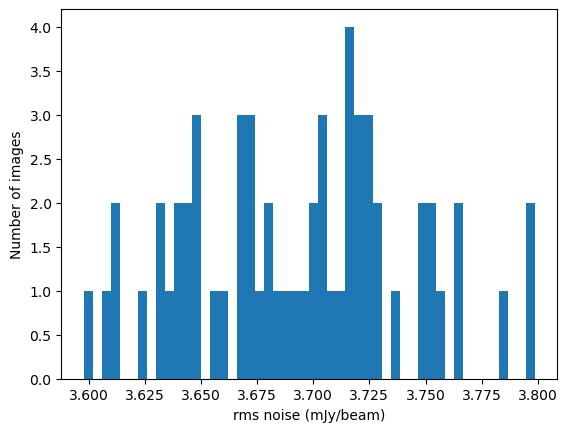

In [8]:
from matplotlib import pyplot as plt 
plt.hist(imageData.rms,bins=50,histtype='stepfilled')

plt.xlabel('rms noise (mJy/beam)')
plt.ylabel('Number of images')

plt.show()

In [9]:
# functions to fit a Gaussian distribution to data

def res(p, y, x):
# calculate residuals between data and Gaussian model
  m1, sd1, a = p
  y_fit = a*norm2(x, m1, sd1)
  err = y - y_fit
  return err

def guess_p(x):
# estimate the mean and rms as initial inputs to the Gaussian fitting
    median = np.median(x)
    temp=[n*n-(median*median) for n in x]
    rms = math.sqrt((abs(sum(temp))/len(x)))
    return [median, rms, math.sqrt(len(x))]

def norm2(x, mean, sd):
# creates a normal distribution in a simple array for plotting
    normdist = []
    for i in range(len(x)):
        normdist += [1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x[i] - mean)**2/(2*sd**2))]
    return np.array(normdist)

In [10]:
from scipy.optimize import leastsq
import math

# Obtain the data in a binned histogram for fitting
hist_rms=np.histogram(imageData.rms,bins=50)
range_x=[hist_rms[1][n]+(hist_rms[1][n+1]-hist_rms[1][n])/2. for n in range(len(hist_rms[1])-1)]

# Guess the mean and standard deviation based upon the median value
p = guess_p(imageData.rms)

# Calculate the best fitting Gaussian distribution
plsq = leastsq(res, p, args = (hist_rms[0], range_x)) # fit Gaussian to data
fit2 = plsq[0][2]*norm2(range_x, plsq[0][0], plsq[0][1]) # create Gaussian distribution for plotting on graph

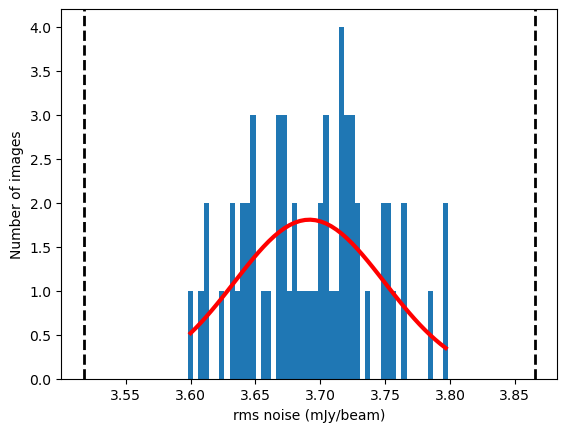

In [11]:
# Create a plot of the results

plt.plot(range_x,fit2, 'r-', linewidth=3)
plt.hist(imageData.rms,bins=50,histtype='stepfilled')

sigcut=plsq[0][0]+plsq[0][1]*sigmaRej # max threshold defined as (mean + RMS * sigma)
sigcut2=plsq[0][0]-plsq[0][1]*sigmaRej # min threshold defined as (mean - RMS * sigma)
plt.axvline(x=sigcut, linewidth=2, color='k',linestyle='--')
plt.axvline(x=sigcut2, linewidth=2, color='k', linestyle='--')

plt.xlabel('rms noise (mJy/beam)')
plt.ylabel('Number of images')

plt.show()

In [12]:
# Thresholds for TraP job parameters file (job_params.cfg):
print('rms_est_max = '+str(sigcut/1e3))
print('rms_est_min = '+str(sigcut2/1e3))

rms_est_max = 0.0038653750946445425
rms_est_min = 0.0035177895537878557


### Running the TraP

The next step in the process is running the TraP on your data. You need to set up the TraP according to the instructions and initiate a job.

The images_to_process.py file will look like with the "path_to_images" used above:

The job_params.cfg file will look like this, with the rms limits from above:

**Some advice for job_params.cfg**

Generally, the default parameters generally work well but you may want to take the following into consideration.

- I recommend preventing the automatic rms thresholding by setting *rms_est_history* to a larger number than the number of images you wish to process. While the current implementation does work, it is very slow so dramatically impacts performance.

- *detection_threshold = 8* you may want to edit this such that you can control the number of false positive detections in your images. For further details, see e.g. Section 4.1 of [Fijma et al. 2024](https://ui.adsabs.harvard.edu/abs/2024MNRAS.528.6985F/abstract).

- *extraction_radius = 250* choose an appropriate source extraction radius in pixels to cover the optimal search area in your images. I recommend that you do not go too close to the image edge.

When you run TraP, make a note of the dataset id for your TraP run and insert it here. Also give the name of the database you are using:

(It's in the screen output, look for this line `tkp.steps.persistence: created dataset 101 (TRAP dataset)`)

In [13]:
dataset_id = 106
database = 'TraP_DB'

You now need to specify your postgresql database, username, password etc. All of this information is in the file pipeline.cfg that you used to setup the TraP. Input this into the file dblogin.py, which looks like:

The database settings are then obtained by simply importing the dblogin.py file.

In [14]:
from dblogin import *

We now open a connection to the database using SQLAlchemy.

In [15]:
import tkp.db
from sqlalchemy import *

db = tkp.db.Database(engine=engine, host=host, port=port, user=user, password=password, database=database)
db.connect()
session = db.Session()

Once this is complete, you can now access the various datasets and associated tables in the following. I recommend using [SQLAlchemy](https://www.sqlalchemy.org), but it is possible to also use SQL commands. In the following, we then consider transients and variables separately.

### Variability Searches


Much of the work in this section is based upon the methods and codes presented in [Rowlinson et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26C....27..111R/abstract) and [Valdata et al. (in prep)]()

TraP measures two variability parameters (see [Swinbank et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015A%26C....11...25S/abstract)):
 - **the reduced weighted &chi;^2 (&eta;)** : This is from a fit to the light curve assuming that the flux density of your source is constant. The larger this value, the less well it fits to a horizontal line and thus the more variable the source is.
 - **the coefficient of variation (V)** : This measures the magnitude of the flux density variation in the light curve. The larger this value, the larger the variation in the flux density measurements and thus the more variable the source is.

For reference, TraP measures this value for every single time step in the light curve. Typically (and in the following code), we just use the value associated with the last data point in the light curve when assessing the variability of sources.

Much of the following code is based on the FilterVariables.py code in [TraP_tools](https://github.com/transientskp/TraP_tools/tree/master).

First, let's get the variability parameters for all the sources in the dataset. We do this by querying the Varmetric and Runningcatalog tables in the TraP database. So first, import the tools required for those tables and then obtain the data from the database.

In [16]:
from tkp.db.model import Varmetric
from tkp.db.model import Runningcatalog

VarParams = session.query(Varmetric,Runningcatalog).select_from(join(Varmetric,Runningcatalog)).filter(Runningcatalog.dataset_id == dataset_id).all()

n.b. the original code checks for duplicate sources in this table. This was because the old version of TraP sometimes misassociated sources and made a duplicate source. Further testing is ongoing to determine if this is also the case for the latest version as the code has been improved. We do not check for duplicates in this notebook.

Next, we pull out the specific columns we require and convert them into a Pandas dataframe.

In [17]:
# Set up data for plotting
plotdata = [[VarParams[i].Runningcatalog.id, VarParams[i].Varmetric.eta_int, VarParams[i].Varmetric.v_int, VarParams[i].Varmetric.lightcurve_max, VarParams[i].Varmetric.lightcurve_median, (VarParams[i].Varmetric.band.freq_central/1e6), VarParams[i].Runningcatalog.datapoints, VarParams[i].Varmetric.newsource] for i in range(len(VarParams))]
plotdata = pd.DataFrame(data=plotdata,columns=['runcat','eta','V','maxFlx','avgFlx','freq','dpts','newSrc'])
plotdata = plotdata.fillna('N')

For simplicity, we ignore all sources that are identified as new sources. These are sources that were not identified in the first image and may be transients. The candidate transients are filtered using a different strategy (see section on Transient Searches).

We also reject any remaining sources that have 0 for one of their variability parameters.

#### Getting the positions of the sources

In [18]:
plotdata = plotdata.loc[(plotdata['eta'] > 0) & (plotdata['V'] > 0) & (plotdata['newSrc']=='N')]
plotdata

,runcat,eta,V,maxFlx,avgFlx,freq,dpts,newSrc
0,1100,0.537736,0.049224,0.196241,0.174455,143.650818,60,N
1,1101,0.551207,0.080565,0.110166,0.097816,143.650818,60,N
2,1102,0.585821,0.060585,0.145019,0.130870,143.650818,60,N
3,1103,0.625761,0.013048,0.950295,0.922642,143.650818,60,N
4,1104,0.283594,0.079599,0.077513,0.065528,143.650818,60,N
...,...,...,...,...,...,...,...,...
323,1427,9.047764,0.180479,0.126939,0.113769,143.650818,60,N
336,1441,18.665686,0.265616,0.126939,0.112593,143.650818,59,N
337,1442,21.716648,0.457507,0.126939,0.049718,143.650818,60,N
375,1480,0.706576,0.103436,0.083297,0.067814,143.650818,60,N


In [19]:
from tkp.db.model import Extractedsource
from tkp.db.model import Assocxtrsource
from tkp.db.model import Image

In [20]:
images= session.query(Image).filter(Image.dataset_id == dataset_id).all()
images = pd.DataFrame(data=[[images[x].url,images[x].taustart_ts,np.around(images[x].band.freq_central/1e9, decimals=3)] for x in range(len(images))], columns=['Image','Time','Freq'])

We now extract the position of the sources from the database.

In [21]:
runcatData = session.query(Runningcatalog).filter(Runningcatalog.dataset_id == dataset_id).all()

positions = [[runcatData[i].id,runcatData[i].wm_ra,runcatData[i].avg_ra_err,runcatData[i].wm_decl,runcatData[i].avg_decl_err] for i in range(len(runcatData))]
positions = pd.DataFrame(data=positions,columns=['runcat','ra','ra_err','dec','dec_err'])

Combine these positions with the variable candidates.

In [22]:
plotdata = pd.merge(plotdata,positions,how='inner', on='runcat')
plotdata

,runcat,eta,V,maxFlx,avgFlx,freq,dpts,newSrc,ra,ra_err,dec,dec_err
0,1100,0.537736,0.049224,0.196241,0.174455,143.650818,60,N,66.779304,0.006711,65.524135,0.002782
1,1101,0.551207,0.080565,0.110166,0.097816,143.650818,60,N,66.461496,0.006644,65.212988,0.002790
2,1102,0.585821,0.060585,0.145019,0.130870,143.650818,60,N,66.081217,0.006472,64.545272,0.002784
3,1103,0.625761,0.013048,0.950295,0.922642,143.650818,60,N,66.095676,0.006586,65.053444,0.002778
4,1104,0.283594,0.079599,0.077513,0.065528,143.650818,60,N,65.924506,0.006499,64.555772,0.002800
...,...,...,...,...,...,...,...,...,...,...,...,...
220,1427,9.047764,0.180479,0.126939,0.113769,143.650818,60,N,62.565227,0.006557,64.902385,0.002783
221,1441,18.665686,0.265616,0.126939,0.112593,143.650818,59,N,62.563052,0.006559,64.902845,0.002784
222,1442,21.716648,0.457507,0.126939,0.049718,143.650818,60,N,62.548710,0.006569,64.906241,0.002791
223,1480,0.706576,0.103436,0.083297,0.067814,143.650818,60,N,60.388423,0.006368,64.041921,0.002794


#### Filtering out sidelobes

Sometimes sidelobes can be detected in the first image as a unique runcat source. We do not want these sources to be flagged as variable so we remove them from the list of sources to be considered.

To see a full analysis of how to handle sidelobes, refer to de Ruiter et al. (2021) and de Ruiter et al. (2023).

Here we conduct a simple cut using a fixed radius and the brightest sources in the field. This reduces the sky area surveyed so will need taking into account if you calculate transient surface density limits.

CAVEAT: This is needed for arrays like LOFAR where sidelobe artefacts occur somewhat frequently. Arrays with dishes, such as MeerKAT, do not typically need this. Look at a batch of your data and see what suits it best.

In [23]:
import astropy.units as u
from astropy.coordinates import SkyCoord

FilterRadius = 4. # in arcmin (taken from table 2 in de Ruiter et al. (2023). This is probably reasonable and conservative for most LOFAR data.
BrightSrcFlx = 0.5 # Jy

# identify the brightest sources
runcat_bright = plotdata.loc[plotdata.avgFlx > BrightSrcFlx]
SrcPos = SkyCoord(ra=(plotdata.ra.values)*u.degree,dec=(plotdata.dec.values)*u.degree)
brightSrcsPos = SkyCoord(ra=(runcat_bright.ra.values)*u.degree,dec=(runcat_bright.dec.values)*u.degree)

idx1, d2d, d3d = SrcPos.match_to_catalog_sky(brightSrcsPos)
plotdata['nearestBrtSrc'] = d2d.deg
plotdata = plotdata.loc[(plotdata.nearestBrtSrc > FilterRadius/60.) | (plotdata.nearestBrtSrc == 0)]

225
217


We can now plot the variability parameters for all the sources detected in the first image.

In [24]:
from astropy.stats import bayesian_blocks

def make_bins(x):
    new_bins = bayesian_blocks(x)
    binsx = [new_bins[a] for a in range(len(new_bins)-1) if abs((new_bins[a+1]-new_bins[a])/new_bins[a])>0.05]
    binsx = binsx + [new_bins[-1]]
    return binsx

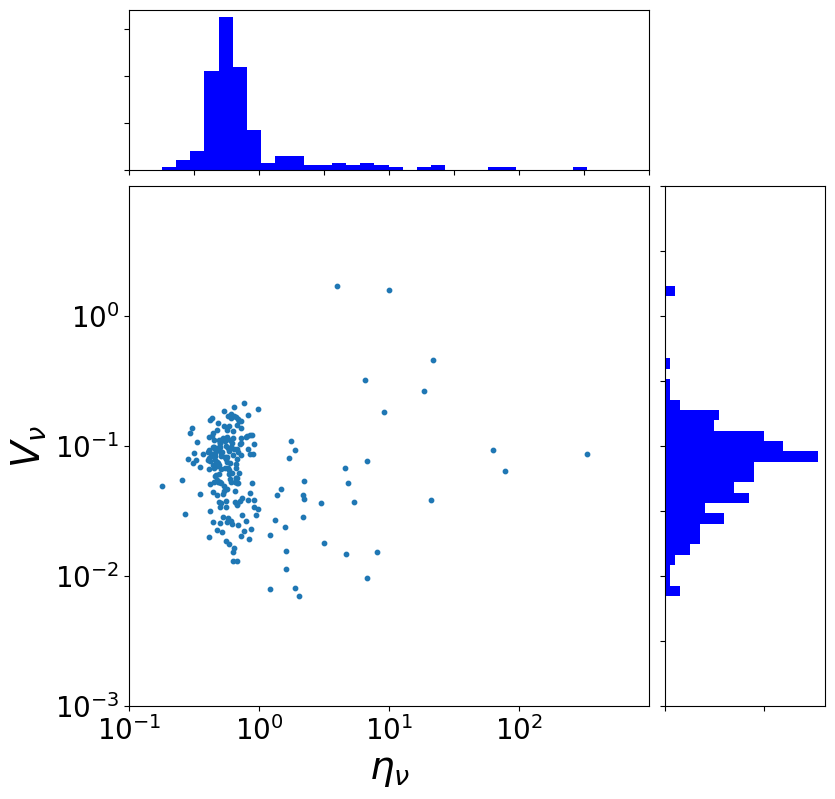

In [25]:
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(8,8))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=28)
plt.ylabel(r'$V_{\nu}$', fontsize=28)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])

xdata_var=np.log10(plotdata['eta'])
ydata_var=np.log10(plotdata['V'])
axScatter.scatter(xdata_var, ydata_var, s=10.)

x = np.log10(plotdata['eta'])
y = np.log10(plotdata['V'])

axHistx.hist(x, bins=30, histtype='stepfilled', color='b')
axHisty.hist(y, bins=30, histtype='stepfilled', orientation='horizontal', color='b')

xmin=int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=20)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=20)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())

plt.show()

In the simplest case, we now define variable sources as those that are significantly deviant from the population. i.e. we assume that the majority of sources in the radio sky are not variable. From experience, this is a pretty reasonable assumption.

We fit the &eta; and V distributions with a Gaussian curve. Then we can specify the number of &sigma; deviant we want to use as the threshold [(see Rowlinson et al. 2019 for more info)](https://ui.adsabs.harvard.edu/abs/2019A%26C....27..111R/abstract). Typically, 2&sigma; gives a reasonable result.

In [26]:
sigmaThresh = 2

In [27]:
from scipy.stats import norm

def SigmaFit(data):
    median = np.median(data)
    std_median = np.sqrt(np.mean([(i-median)**2. for i in data]))
    tmp_data = [a for a in data if a < 3.*std_median+median and a > median - 3.*std_median]
    param1 = norm.fit(tmp_data)
    param2 = norm.fit(data)
    return param1, param2

In [28]:
paramx, paramx2 = SigmaFit(np.log10(plotdata['eta']))
paramy, paramy2 = SigmaFit(np.log10(plotdata['V']))

print('Gaussian Fit eta: '+str(round(10.**paramx[0],2))+'(+'+str(round((10.**(paramx[0]+paramx[1])-10.**paramx[0]),2))+' '+str(round((10.**(paramx[0]-paramx[1])-10.**paramx[0]),2))+')')
print('Gaussian Fit V: '+str(round(10.**paramy[0],2))+'(+'+str(round((10.**(paramy[0]+paramy[1])-10.**paramy[0]),2))+' '+str(round((10.**(paramy[0]-paramy[1])-10.**paramy[0]),2))+')')

sigcutx = paramx[1]*sigmaThresh+paramx[0]
sigcuty = paramy[1]*sigmaThresh+paramy[0]

print('eta threshold = '+str(round(10.**sigcutx,2)))
print('V threshold = '+str(round(10.**sigcuty,2)))

Gaussian Fit eta: 0.7(+0.67 -0.34)
Gaussian Fit V: 0.06(+0.07 -0.03)
eta threshold = 2.67
V threshold = 0.27


We can now use these thresholds to identify which sources are variable and illustrate it in the plot.

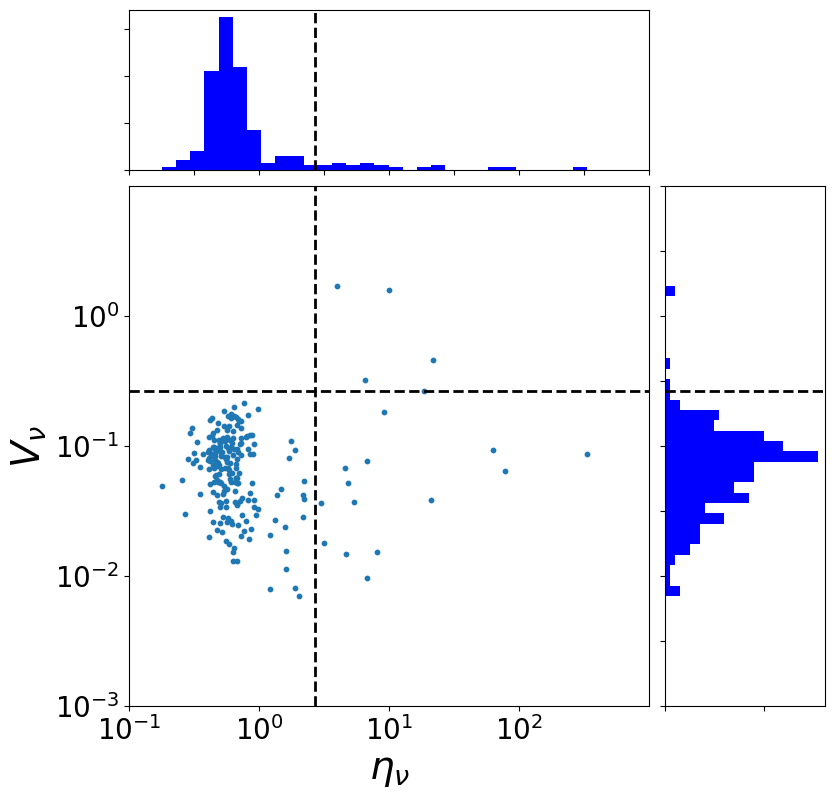

In [29]:

nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(8,8))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=28)
plt.ylabel(r'$V_{\nu}$', fontsize=28)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])

xdata_var=np.log10(plotdata['eta'])
ydata_var=np.log10(plotdata['V'])
axScatter.scatter(xdata_var, ydata_var, s=10.)

x = np.log10(plotdata['eta'])
y = np.log10(plotdata['V'])

#axHistx.hist(x, bins=make_bins(x), histtype='stepfilled', color='b')
#axHisty.hist(y, bins=make_bins(y), histtype='stepfilled', orientation='horizontal', color='b')
axHistx.hist(x, bins=30, histtype='stepfilled', color='b')
axHisty.hist(y, bins=30, histtype='stepfilled', orientation='horizontal', color='b')

axHistx.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')
axHisty.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
axScatter.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
axScatter.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')

xmin=int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=20)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=20)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())

plt.show()

In [30]:
variables = plotdata.loc[(plotdata['eta']>=10.**sigcutx) & (plotdata['V']>=10.**sigcuty)]
variables

,runcat,eta,V,maxFlx,avgFlx,freq,dpts,newSrc,ra,ra_err,dec,dec_err,nearestBrtSrc
76,1176,9.977918,1.588685,0.066080,0.002181,143.650818,5,N,62.796093,0.007020,66.442961,0.002813,0.242904
119,1220,3.966615,1.702974,0.058535,0.006127,143.650818,2,N,61.431206,0.006280,63.334081,0.002828,0.244731
219,1368,6.469143,0.322597,0.126939,0.047178,143.650818,60,N,62.543596,0.006575,64.907343,0.002795,0.414671
221,1441,18.665686,0.265616,0.126939,0.112593,143.650818,59,N,62.563052,0.006559,64.902845,0.002784,0.421162
222,1442,21.716648,0.457507,0.126939,0.049718,143.650818,60,N,62.548710,0.006569,64.906241,0.002791,0.416391


Obviously, the next step is to plot the light curve to confirm the variability visually. Usually we also want to visually inspect to check for artefacts so we will also load the image. Automating this step is underway for some types of artefacts - such as sidelobes of bright sources.

Assuming the images are still available, we can plot the source and its surroundings. To do this, we need to pull the full light curve for the sources out of the database and we need to access three new tables.

In [31]:
def extract_data(fits_file_path, ra, dec, size):    
    hdu = fits.open(fits_file_path)[0]
    data1 = hdu.data
    wmap = WCS(hdu.header, naxis=2)
    data1 = data1[0][0]
    return data1, wmap


def fix_axes_limits_ax1(ax1, RA_coord, DEC_coord, wmap,pix_lim):
    """Define a window of 2*pix_lim around the center coordinate in LoTSS."""
    px, py = wmap.wcs_world2pix(RA_coord, DEC_coord, 1)
    ax1.set_xlim(px-pix_lim, px+pix_lim)
    ax1.set_ylim(py-pix_lim, py+pix_lim)

    RA_min, DEC_min = wmap.wcs_pix2world(px-pix_lim, py-pix_lim, 1)
    RA_max, DEC_max = wmap.wcs_pix2world(px+pix_lim, py+pix_lim, 1)

    return px, py, RA_min, DEC_min, RA_max, DEC_max



Runcat = 1176


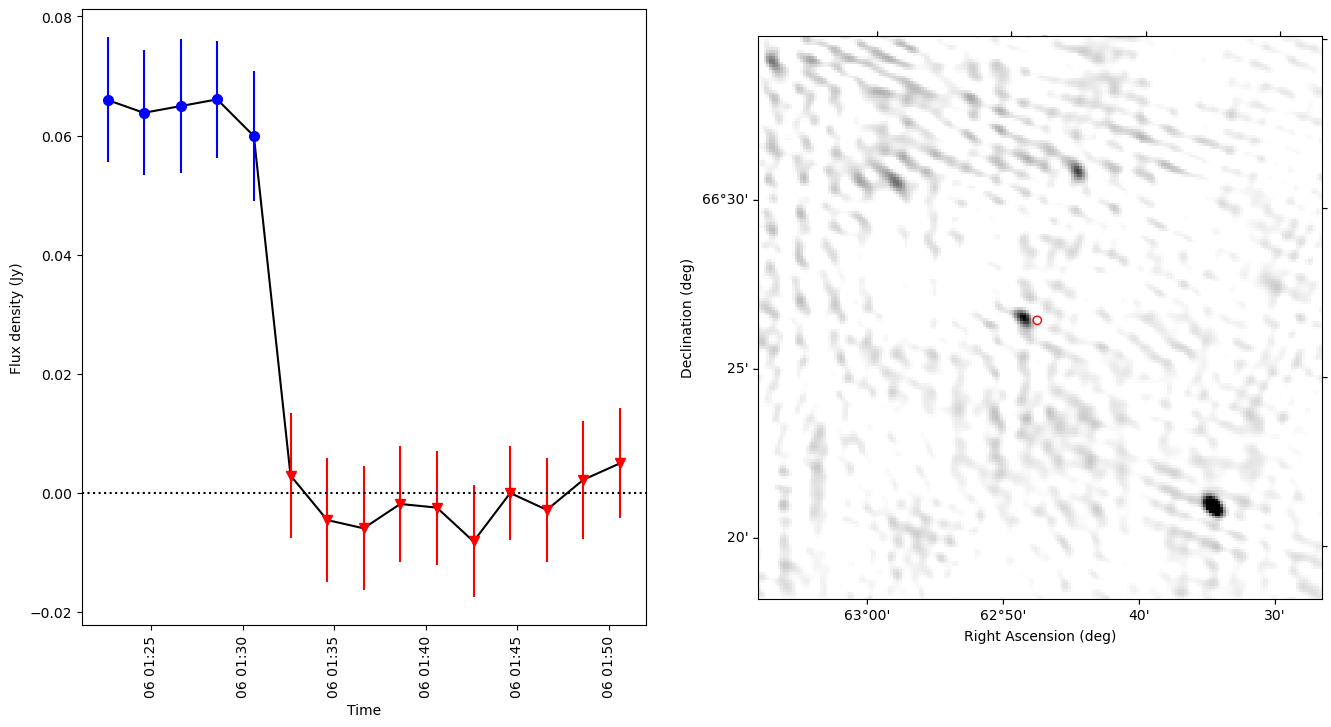

62.79609346227885 66.44296128547195
Runcat = 1220


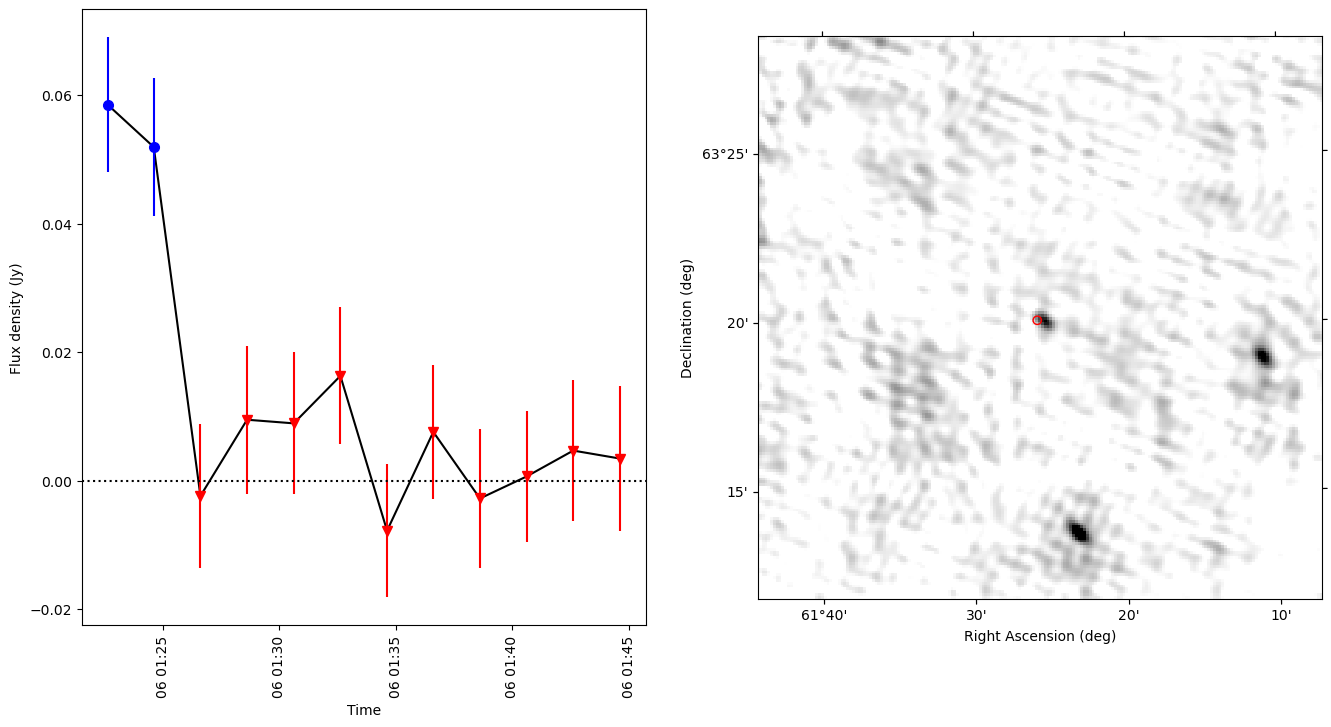

61.431205926373224 63.33408105619176
Runcat = 1368


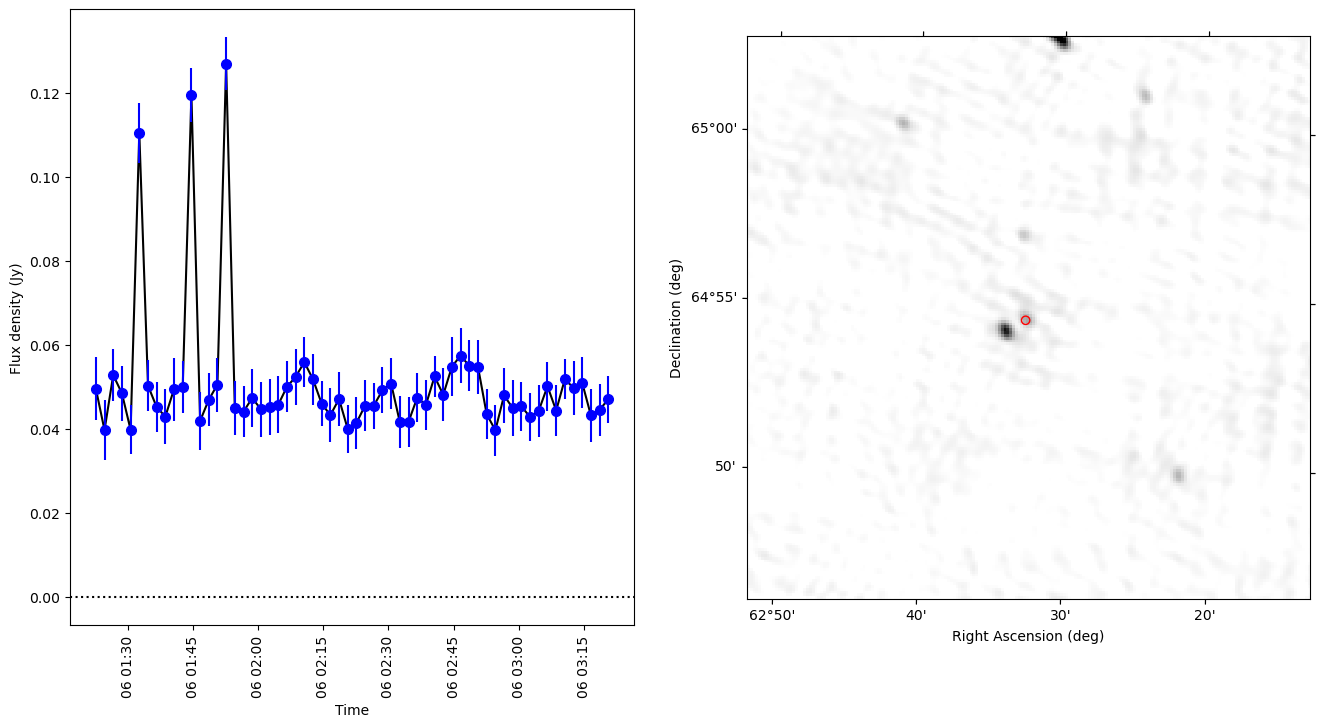

62.54359593492305 64.90734272817527
Runcat = 1441


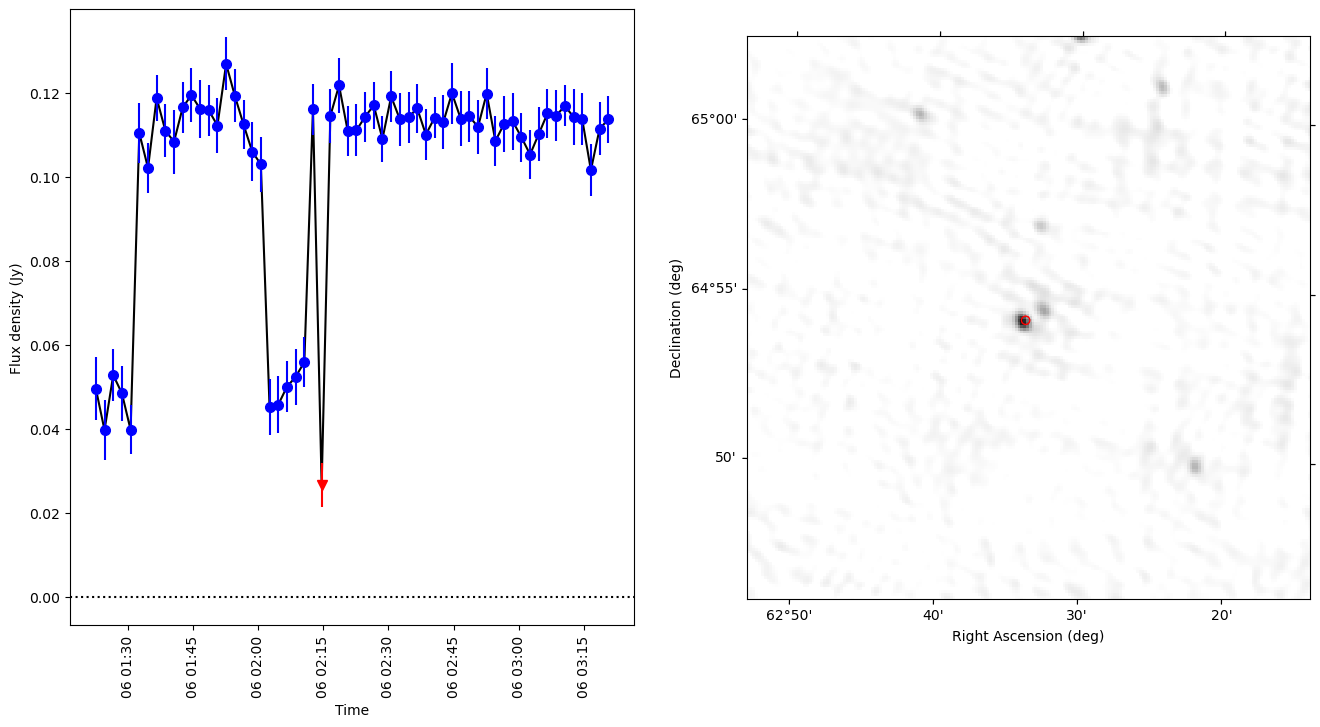

62.563052148558405 64.90284549714846
Runcat = 1442


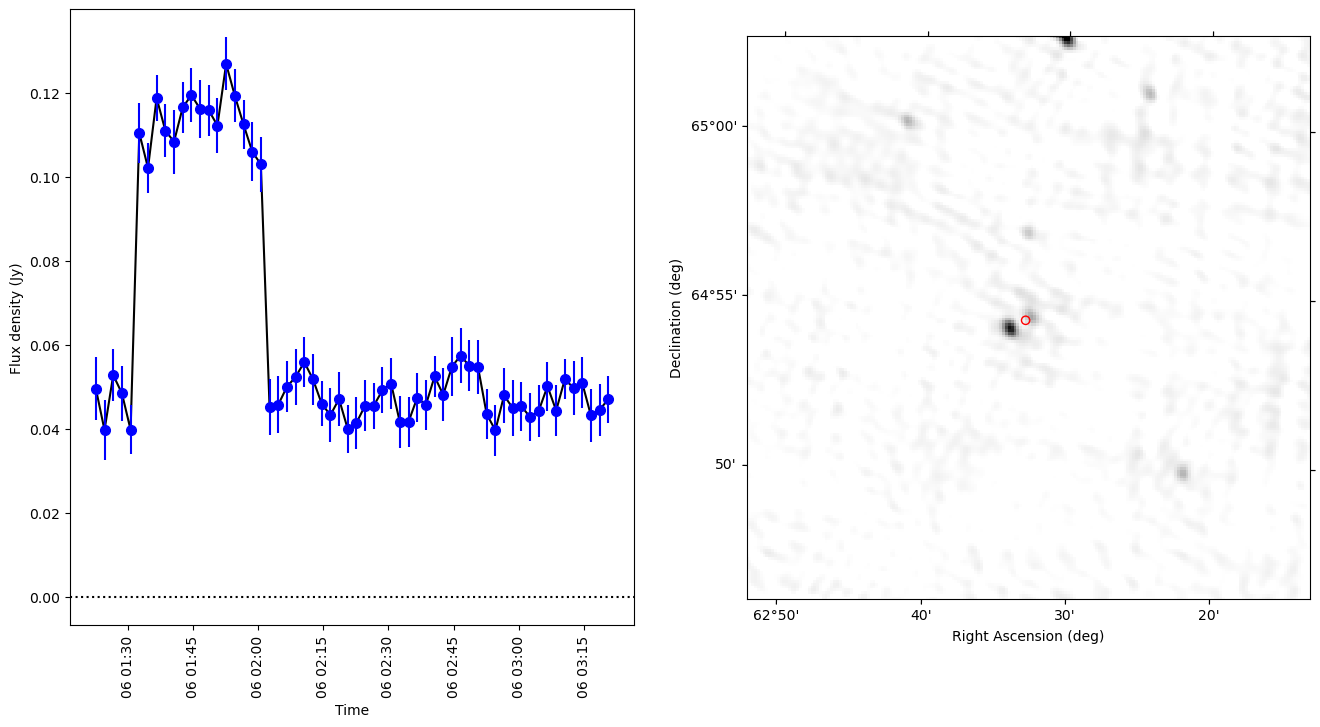

62.54871002169471 64.9062410028239


/var/folders/qq/hqkg8wbn0_x0ntnfbm2c5ktr0000gn/T/ipykernel_49813/525403617.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['maxImg']=maxImgs


In [32]:
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.patches import Ellipse

size = 100
maxImgs=[]
for index, row in variables.iterrows():
    sourceID = row.runcat
    flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type'])
    lightcurve = pd.merge(lightcurve, images, on="Image")

    print('Runcat = '+str(sourceID))
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.type==0:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.type==1:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')

    maxFlux = np.max(lightcurve.Flux)
    maxFluxImg = lightcurve.loc[lightcurve.Flux==maxFlux]
    maxImgs.append(maxFluxImg.iloc[0].Image)


    
    extractedData, wcs = extract_data(maxFluxImg.iloc[0].Image,row.ra,row.dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)
    fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()

    print(row.ra,row.dec)

variables['maxImg']=maxImgs


Once you've confirmed the transient candidate is not an artefact, it is useful to determine if there is an associated known source at the location. To do this, we typically query [Simbad](https://simbad.u-strasbg.fr/simbad/) and this can be done automatically within Python.

In [33]:
from astroquery.simbad import Simbad
import astropy.coordinates as coord

searchRadius = 30. # in arcsec
searchRadius = (searchRadius/3600.)*u.deg

for index, row in variables.iterrows():
    sourceID = row.runcat
    print('Runcat = '+str(sourceID)+' position error = '+str(max(row.ra_err,row.dec_err)*3600)+' arcsec')
    result_table = Simbad.query_region(coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), radius=searchRadius)
    srcPos=coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5')
    if result_table:
        results = [[row['MAIN_ID'], row['RA'], row['DEC'], srcPos.separation(SkyCoord(str(row['RA'])+' '+str(row['DEC']), unit=(u.hourangle, u.deg))).arcsec ] for row in result_table]
        results = pd.DataFrame(results, columns = ['ID','ra','dec','separation'])
        print(results)
    else:
        print('no matches')
    

Runcat = 1176 position error = 25.27341342544822 arcsec


no matches
Runcat = 1220 position error = 22.609351288152972 arcsec
no matches
Runcat = 1368 position error = 23.670196849741377 arcsec
no matches
Runcat = 1441 position error = 23.611957064487832 arcsec
                    ID          ra        dec  separation
0  NVSS J041015+645408  04 10 15.5  +64 54 07    4.024363
Runcat = 1442 position error = 23.65000496625732 arcsec
                    ID          ra        dec  separation
0  NVSS J041015+645408  04 10 15.5  +64 54 07   28.780393


### Variability Searches - version 2

We have noticed that the variability parameters we use show a correlation with the maximum flux density of the source. We show this correlation here:

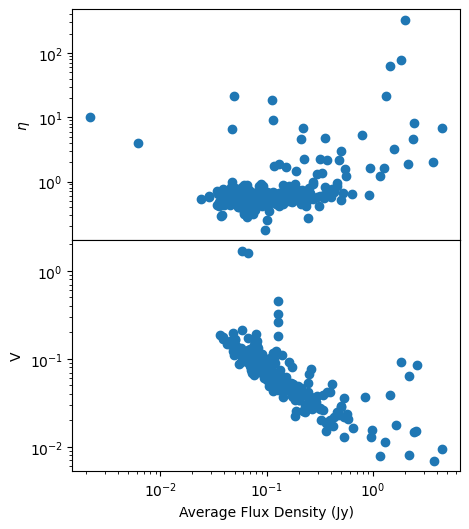

In [34]:
fig = plt.figure(figsize=(5, 6))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
axs[0].scatter(plotdata.avgFlx,plotdata.eta)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel(r'$\eta$')
axs[1].scatter(plotdata.maxFlx,plotdata.V)
axs[1].set_yscale('log')
#axs[1].set_xscale('log')
axs[1].set_ylabel('V')
axs[1].set_xlabel('Average Flux Density (Jy)')
for ax in axs:
    ax.label_outer()

Recent work by [Valdata et al. (in prep)]() takes into account this correlation. It fits the distribution with a linear function and then determines the distances of each data point from the correlation. As we only care about variable sources, we only select the sources that lie above the correlation. We convert to using the log10 values of the variability parameters and flux densities to simplify the code. In the following, we show a simplified version of the code - please refer to the [GitHub repository](https://github.com/ruggerovaldata/Separating-Candidate-Transients/tree/main) for the main code.

In [35]:
plotdata['logEta'] = plotdata.apply(lambda row: np.log10(row.eta), axis=1)
plotdata['logV'] = plotdata.apply(lambda row: np.log10(row.V), axis=1)
plotdata['logFlux'] = plotdata.apply(lambda row: np.log10(row.maxFlx), axis=1)

/var/folders/qq/hqkg8wbn0_x0ntnfbm2c5ktr0000gn/T/ipykernel_49813/1269240526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['logEta'] = plotdata.apply(lambda row: np.log10(row.eta), axis=1)
/var/folders/qq/hqkg8wbn0_x0ntnfbm2c5ktr0000gn/T/ipykernel_49813/1269240526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['logV'] = plotdata.apply(lambda row: np.log10(row.V), axis=1)
/var/folders/qq/hqkg8wbn0_x0ntnfbm2c5ktr0000gn/T/ipykernel_49813/1269240526.py:3: SettingWithCopyWarning: 
A v

We import the scripts used by Valdata et al. (in prep).

In [36]:
import myplotting as myplt
import functions as func

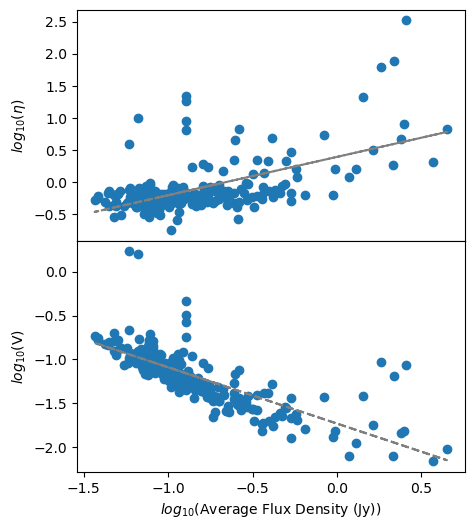

In [37]:
import scipy.optimize as spopt
import scipy.stats as spstat

freq = plotdata.freq.unique()
#Finding the line that best represents the two parameters of the data
best_params_eta, ml_cfcovar_linear = spopt.curve_fit(func.LinearFit, plotdata.logFlux, plotdata.logEta)
best_params_V, ml_cfcovar_linear = spopt.curve_fit(func.LinearFit, plotdata.logFlux, plotdata.logV)

m_eta, q_eta = best_params_eta[0],best_params_eta[1]
m_V, q_V = best_params_V[0],best_params_V[1]
y_eta = func.LinearFit(plotdata.logFlux,m_eta,q_eta)
y_V = func.LinearFit(plotdata.logFlux,m_V,q_V)

fig = plt.figure(figsize=(5, 6))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
axs[0].scatter(plotdata.logFlux,plotdata.logEta)
axs[0].set_ylabel(r'$log_{10}$($\eta$)')
axs[0].plot(plotdata.logFlux,y_eta,label='Best fit',color='gray', ls='--')
axs[1].scatter(plotdata.logFlux,plotdata.logV)
axs[1].set_ylabel(r'$log_{10}$(V)')
axs[1].set_xlabel(r'$log_{10}$(Average Flux Density (Jy))')
axs[1].plot(plotdata.logFlux,y_V,label='Best fit',color='gray',ls='--')
for ax in axs:
    ax.label_outer()


Now we extract only the data points that lie above this line.

In [38]:
#Calculating the paramater distance from the line that has been found earlier
plotdata['distsEta'] = plotdata.apply(lambda row: func.Params_distance(row.logEta,func.LinearFit(row.logFlux,m_eta,q_eta)), axis=1)
plotdata['distsV'] = plotdata.apply(lambda row: func.Params_distance(row.logV,func.LinearFit(row.logFlux,m_V,q_V)), axis=1)

dataBest = plotdata.loc[(plotdata['distsEta'] > 0) & (plotdata['distsV'] > 0)]

/var/folders/qq/hqkg8wbn0_x0ntnfbm2c5ktr0000gn/T/ipykernel_49813/3910120889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['distsEta'] = plotdata.apply(lambda row: func.Params_distance(row.logEta,func.LinearFit(row.logFlux,m_eta,q_eta)), axis=1)
/var/folders/qq/hqkg8wbn0_x0ntnfbm2c5ktr0000gn/T/ipykernel_49813/3910120889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['distsV'] = plotdata.apply(lambda row: func.Params_distance(row.logV,func.LinearFit(row.logFlux,m_V,q_V)), axis=1)


Now plot the distances from the two lines and fit a multivariate normal distribution to the data. We can then use this fit to determine which sources are outliers to the distribution.

/var/folders/qq/hqkg8wbn0_x0ntnfbm2c5ktr0000gn/T/ipykernel_49813/452078645.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataBest['probability'] = 100.-outliers_prob


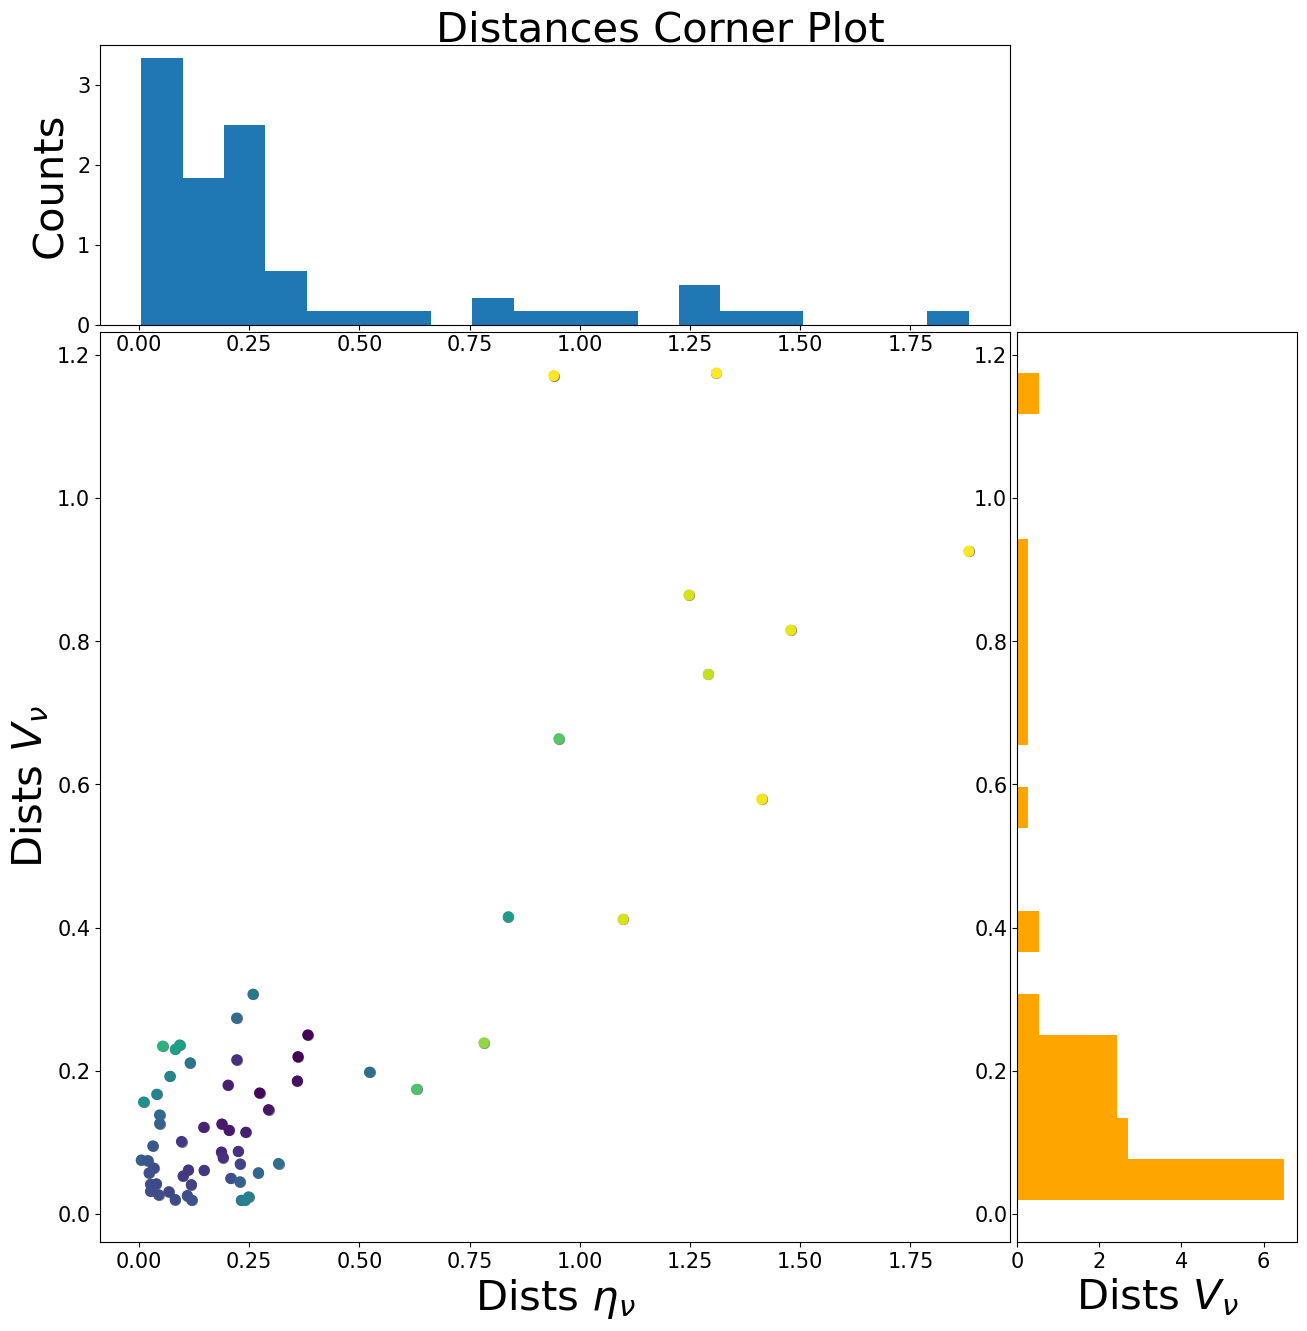

In [39]:
p = 0.99 #Inserting here the percentage with which the source should be classified as inlier

data_graph = np.vstack([dataBest.distsEta,dataBest.distsV])
data_graph = data_graph.T

mean_deta = np.mean(dataBest.distsEta)
mean_dV = np.mean(dataBest.distsV)
mu = [mean_deta,mean_dV]

cov_matrix = np.cov(dataBest.distsEta,dataBest.distsV)
likelihood = spstat.multivariate_normal.pdf(data_graph,[mean_deta,mean_dV],cov_matrix)

outliers_prob = func.Probability(data_graph,mu,cov_matrix) #Calculating the probability for every parameter of being associated to an "inlier" source

dataBest['probability'] = 100.-outliers_prob
temp = dataBest.sort_values('probability')
dataBest.to_csv('WholedatasetoutputBest.csv', index=False)

figure, axes = myplt.MyCorner(dataBest.distsEta,dataBest.distsV,dataBest.probability/100.,'CornerPlotBest') #Printing the corner plot both with the likelihood and without the likelihood

chi2 = spstat.chi2.ppf([p],2)[0]

# finding the outliers with probabilities >99% and with positive distances abovve the trend line
inliersBest = dataBest.loc[ (dataBest['probability'] <= p*100.) ]
outliersBest = dataBest.loc[ (dataBest['probability'] > p*100.) ]


Text(125.97222222222221, 0.5, '$log_{10}(V_{\\nu})$')

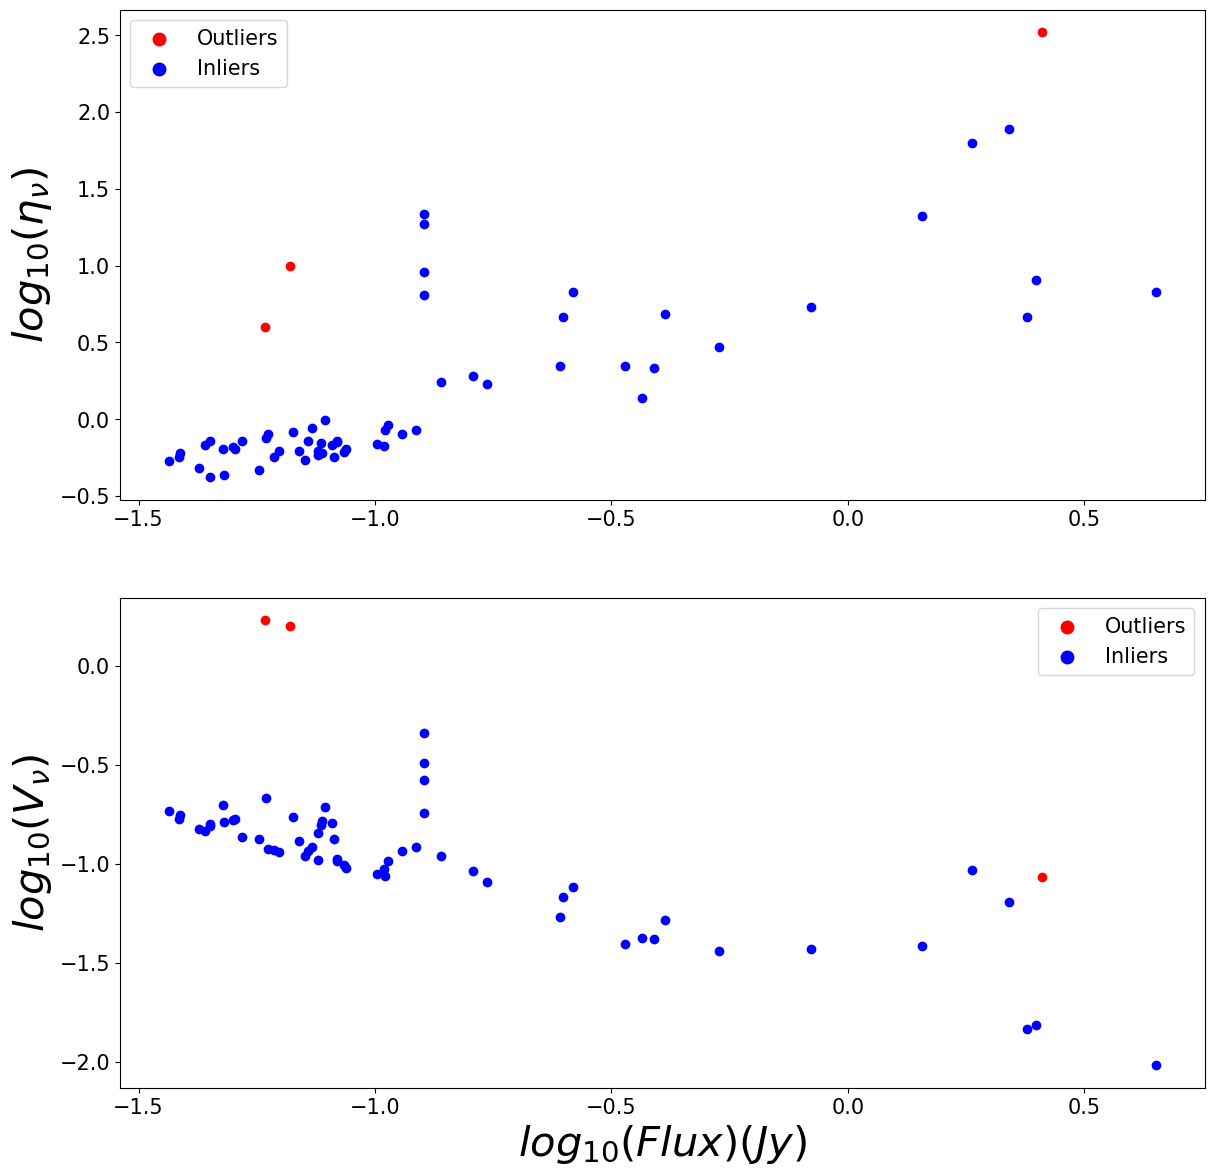

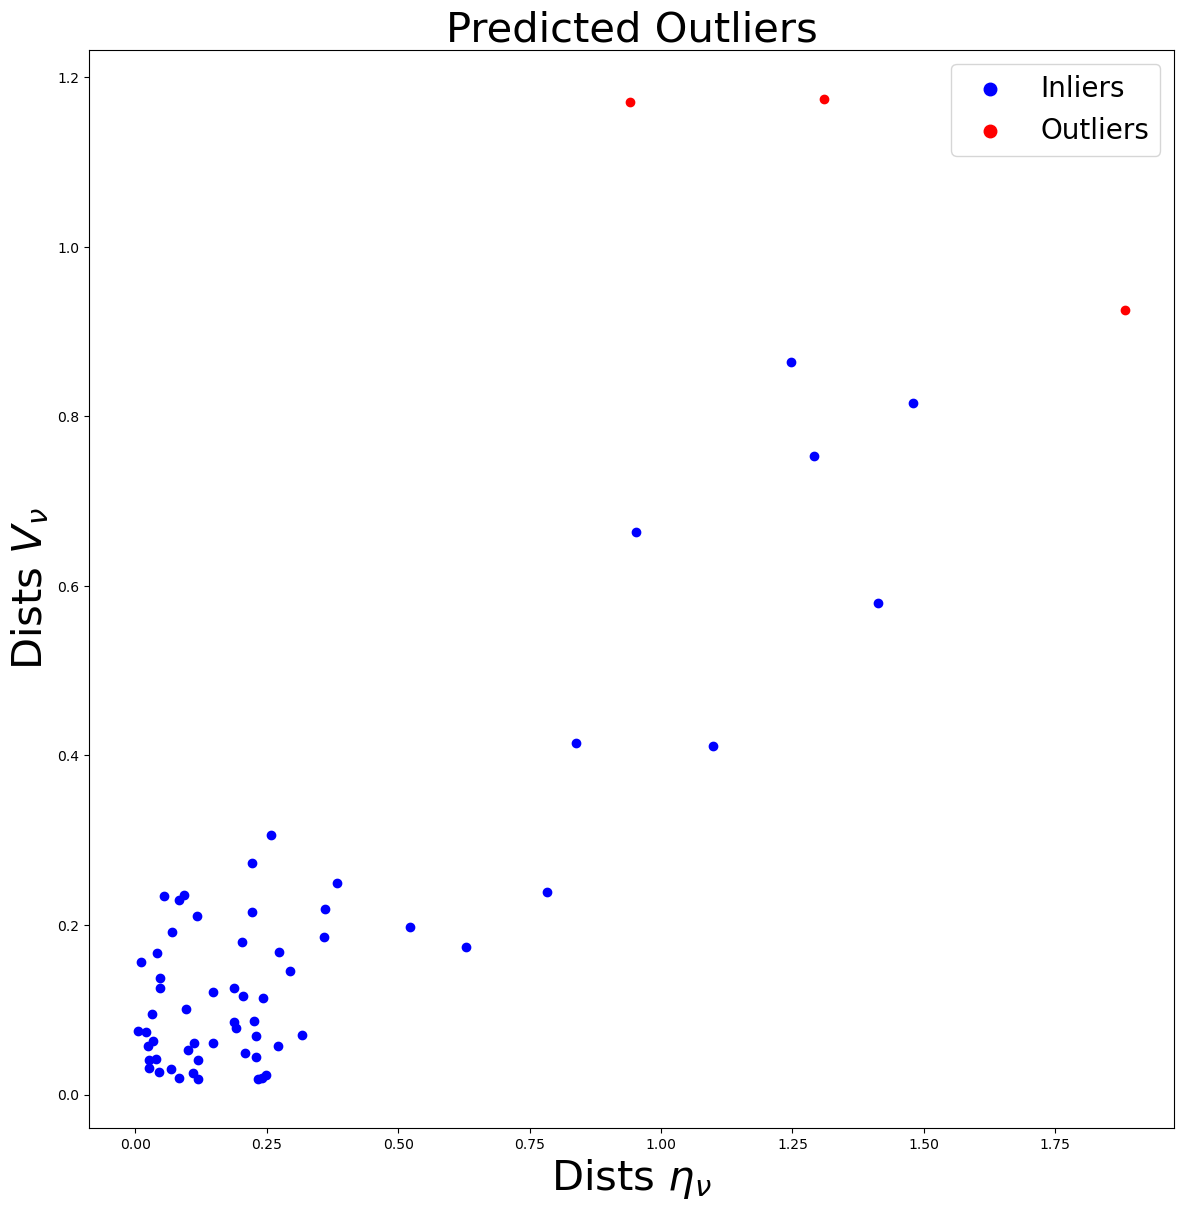

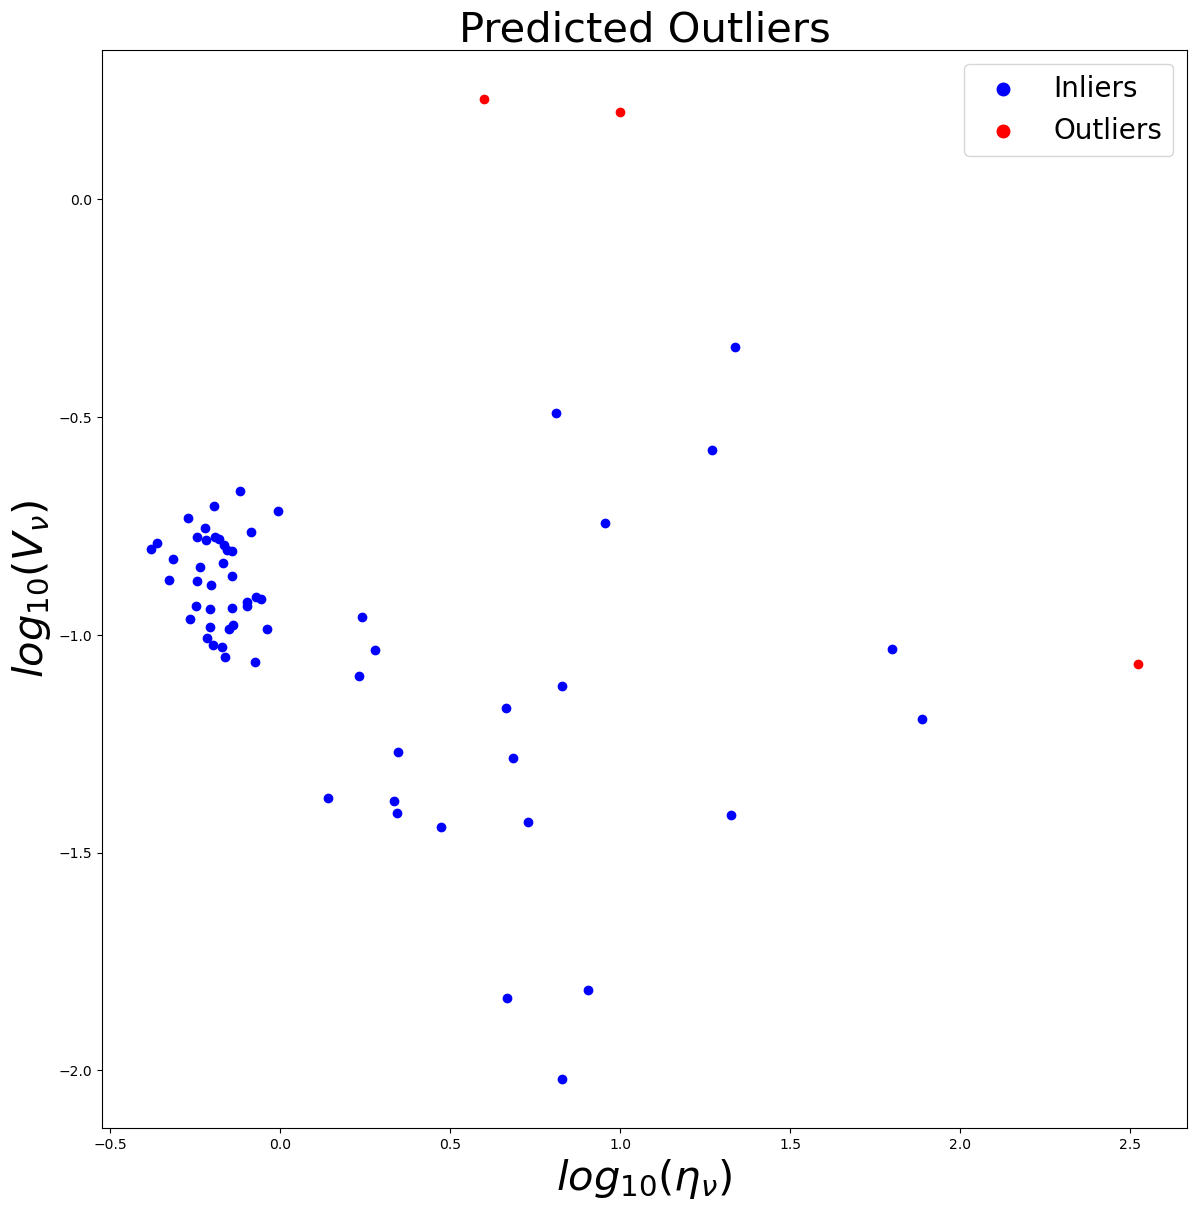

In [40]:
# Plotting
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,14))

ax1.scatter(outliersBest.logFlux,outliersBest.logEta,color='red',label='Outliers')
ax1.scatter(inliersBest.logFlux,inliersBest.logEta,color='blue',label='Inliers')
ax2.scatter(outliersBest.logFlux,outliersBest.logV,color='red',label='Outliers')
ax2.scatter(inliersBest.logFlux,inliersBest.logV,color='blue',label = 'Inliers')

ax1.set_ylabel(r'$log_{10}(\eta_{\nu}$)',fontsize=30)
ax2.legend(fontsize=15,markerscale=1.5)
ax1.legend(fontsize=15,markerscale=1.5)
ax2.set_ylabel(r'$log_{10}(V_{\nu}$)',fontsize=30)
ax2.set_xlabel(r'$log_{10}(Flux) (Jy)$',fontsize=30)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
plt.savefig('EtavsVscatterinoutBest')

figure,ax = myplt.OutInPlot(np.array([outliersBest.distsEta, outliersBest.distsV]).T,np.array([inliersBest.distsEta,inliersBest.distsV]).T,'OutIn_UnstableBest')
EtaVsVout, axveta = myplt.OutInPlot(np.array([outliersBest.logEta, outliersBest.logV]).T,np.array([inliersBest.logEta,inliersBest.logV]).T,'OutInEtavsVBest')
axveta.set_xlabel(r'$log_{10}(\eta_{\nu})$',fontsize=30)
axveta.set_ylabel(r'$log_{10}(V_{\nu})$',fontsize=30)


In [41]:
# Outputting variable candidates
print('Number of outliers : ', len(outliersBest))

if len(outliersBest) == 0:
    print('No candidate variable sources found.')
else:
    print(outliersBest.runcat)

Number of outliers :  3
76     1176
117    1218
119    1220
Name: runcat, dtype: int64


Now we can look at the light curves and images as with the previous variability searches.

In [42]:
variables = outliersBest
#variables = pd.merge(variables,positions,how='inner', on='runcat')
variables

,runcat,eta,V,maxFlx,avgFlx,freq,dpts,newSrc,ra,ra_err,dec,dec_err,nearestBrtSrc,logEta,logV,logFlux,distsEta,distsV,probability
76,1176,9.977918,1.588685,0.066080,0.002181,143.650818,5,N,62.796093,0.007020,66.442961,0.002813,0.242904,0.999040,0.201038,-1.179929,1.310096,1.174719,99.936765
117,1218,332.113317,0.085859,2.581222,2.005903,143.650818,60,N,61.408915,0.006553,64.919225,0.002778,0.000000,2.521286,-1.066216,0.411825,1.882090,0.925718,99.889959
119,1220,3.966615,1.702974,0.058535,0.006127,143.650818,2,N,61.431206,0.006280,63.334081,0.002828,0.244731,0.598420,0.231208,-1.232584,0.940911,1.171205,99.998838


Runcat = 1176


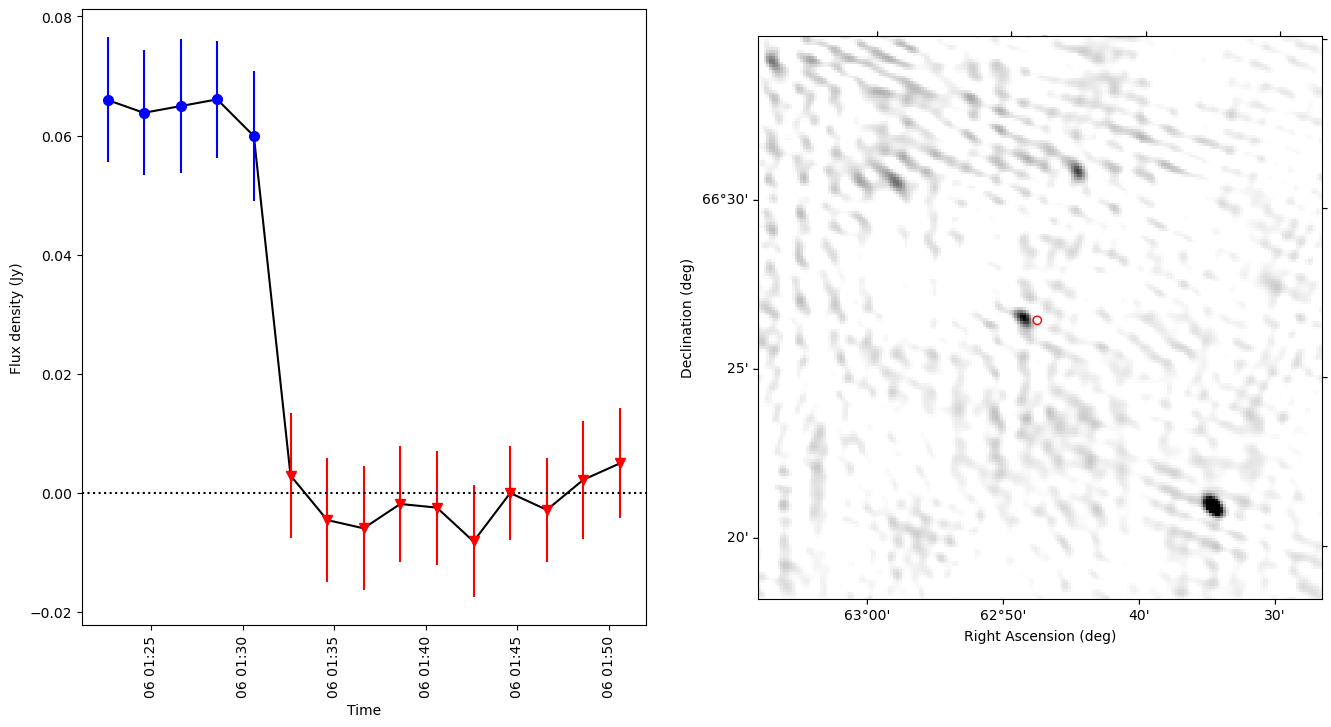

Runcat = 1218


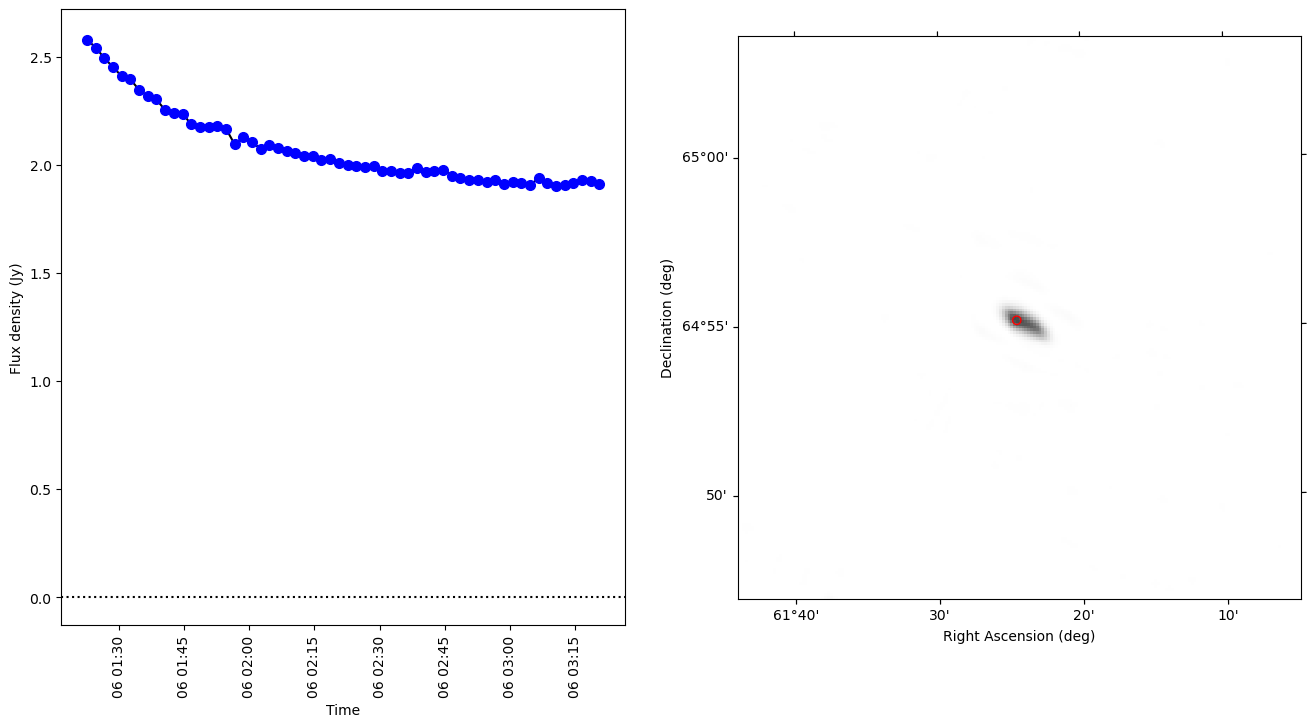

Runcat = 1220


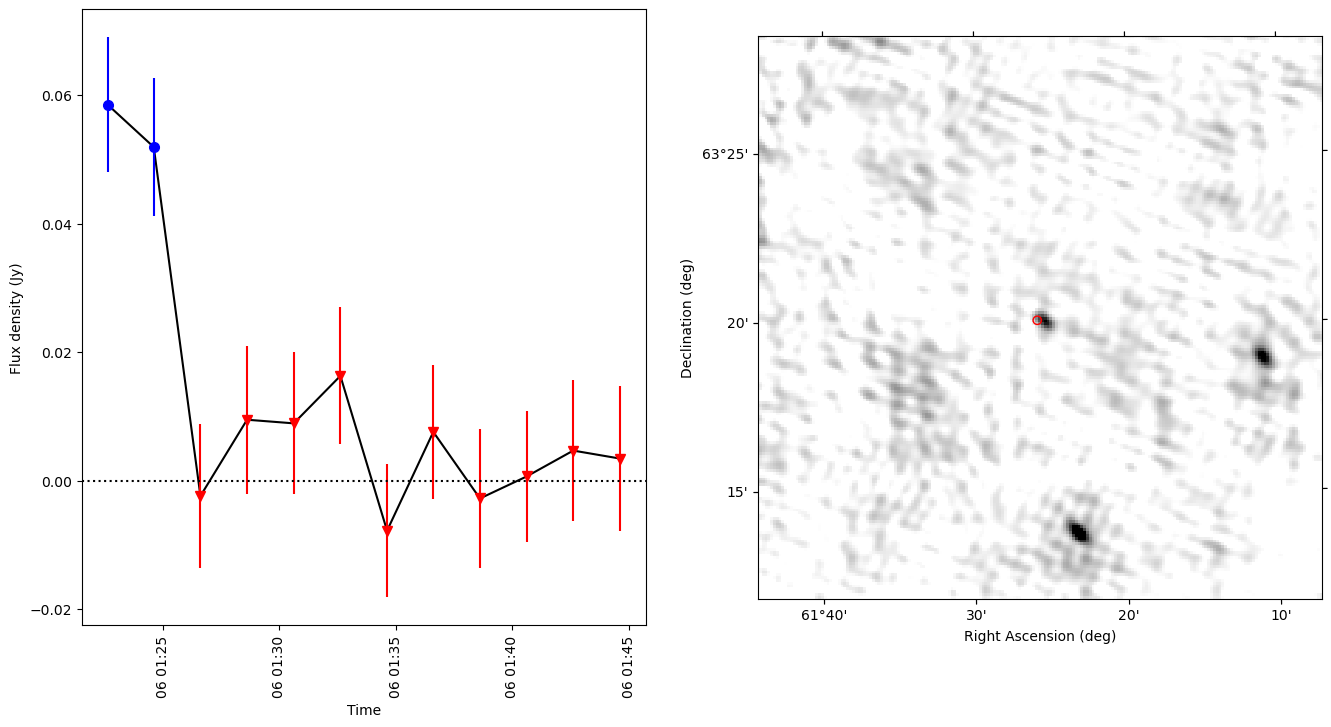

/var/folders/qq/hqkg8wbn0_x0ntnfbm2c5ktr0000gn/T/ipykernel_49813/3937462357.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['maxImg']=maxImgs


In [43]:
maxImgs=[]
for index, row in variables.iterrows():
    sourceID = row.runcat
    flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type'])
    lightcurve = pd.merge(lightcurve, images, on="Image")

    print('Runcat = '+str(sourceID))
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.type==0:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.type==1:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')

    maxFlux = np.max(lightcurve.Flux)
    maxFluxImg = lightcurve.loc[lightcurve.Flux==maxFlux]
    maxImgs.append(maxFluxImg.iloc[0].Image)

    extractedData, wcs = extract_data(maxFluxImg.iloc[0].Image,row.ra,row.dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)
    fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
 
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()
    
variables['maxImg']=maxImgs

In [44]:
for index, row in variables.iterrows():
    sourceID = row.runcat
    print('Runcat = '+str(sourceID)+' position error = '+str(max(row.ra_err,row.dec_err)*3600)+' arcsec')
    result_table = Simbad.query_region(coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), radius=searchRadius)
    srcPos=coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5')
    if result_table:
        results = [[row['MAIN_ID'], row['RA'], row['DEC'], srcPos.separation(SkyCoord(str(row['RA'])+' '+str(row['DEC']), unit=(u.hourangle, u.deg))).arcsec ] for row in result_table]
        results = pd.DataFrame(results, columns = ['ID','ra','dec','separation'])
        print(results)
    else:
        print('no matches')

Runcat = 1176 position error = 25.27341342544822 arcsec
no matches
Runcat = 1218 position error = 23.59083169097664 arcsec
         ID          ra        dec  separation
0  4C 64.05  04 05 36.4  +64 55 05   11.816054
Runcat = 1220 position error = 22.609351288152972 arcsec
no matches


### Transient searches

The previous methods focused on sources that were identified in the first image in a dataset and are looking for significant variability. Another key science case is transient sources, namely sources that were not detected in the first image and were found in subsequent images. The TraP has a specific table for newly identified sources, [newsource](https://tkp.readthedocs.io/en/release4.0/devref/database/schema.html#newsource). 

The following code is based upon the *filter_new_sources.py* example code in the [TraP_tools](https://github.com/transientskp/TraP_tools) repository.

In [45]:
from tkp.db.model import Newsource
NewSrcs = session.query(Newsource, Runningcatalog).select_from(join(Newsource, Runningcatalog)).filter(Runningcatalog.dataset_id ==dataset_id).all()

In [46]:
NewSrcData=[[NewSrcs[i].Runningcatalog.id,NewSrcs[i].Newsource.trigger_xtrsrc.ra,NewSrcs[i].Newsource.trigger_xtrsrc.decl,NewSrcs[i].Newsource.trigger_xtrsrc.id,
             NewSrcs[i].Newsource.trigger_xtrsrc.image.taustart_ts,NewSrcs[i].Newsource.trigger_xtrsrc.det_sigma,NewSrcs[i].Newsource.newsource_type,
             SkyCoord(ra=(NewSrcs[i].Runningcatalog.wm_ra*u.degree),dec=(NewSrcs[i].Runningcatalog.wm_decl*u.degree)),NewSrcs[i].Newsource.trigger_xtrsrc.image.url] for i in range(len(NewSrcs))]
NewSrcDataFrame = pd.DataFrame(data=NewSrcData, columns=['RuncatID','ra','dec','xtrsrc','TimeDetect','detSigma','type','SkyCoord','detectImage'])
NewSrcDataFrame = NewSrcDataFrame.sort_values(by=['RuncatID'])
NewSrcDataFrame

,RuncatID,ra,dec,xtrsrc,TimeDetect,detSigma,type,SkyCoord,detectImage
0,1320,65.179647,63.773028,44367,2020-10-06 01:24:36.600,8.510532,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (65.18...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...
1,1321,62.920713,63.137523,44420,2020-10-06 01:24:36.600,8.302650,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (62.92...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...
2,1322,62.625373,63.960107,44424,2020-10-06 01:24:36.600,8.957573,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (62.62...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...
3,1323,62.520150,66.633487,44435,2020-10-06 01:24:36.600,10.826738,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (62.52...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...
4,1324,62.364157,64.830835,44438,2020-10-06 01:24:36.600,8.674613,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (62.36...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...
...,...,...,...,...,...,...,...,...,...
157,1487,63.414087,66.419314,59850,2020-10-06 03:10:37.400,9.430944,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (63.42...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...
158,1488,61.994605,63.314981,59890,2020-10-06 03:10:37.400,8.296052,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (62.00...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...
159,1489,63.455044,66.426346,60992,2020-10-06 03:18:37.100,12.213085,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (63.45...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...
160,1490,62.028291,63.321976,61034,2020-10-06 03:18:37.100,8.093718,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (62.02...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...


**xtrsrc** is the id of the extracted source that was the first detection of this source

**TimeDetect** is the detection time of the new source

**detSigma** is the significance of the new source detection

**type** Refers to how certain we are that the newly discovered source is really “physically new”, i.e. transient. Since we do not store fine-grained noise-maps in the database, we must be fairly conservative in our labelling here. Type 0 sources may be a steady source located in a high-RMS region, newly detected due to noise fluctuations, or may be a real transient in a low-RMS region. Type 1 sources are bright enough that we can be fairly certain they are really new - they are significantly brighter than the rms_max in the previous image with best detection limits. (definition from the TraP documentation for the [newsource table](https://tkp.readthedocs.io/en/release4.0/devref/database/schema.html#newsource).)

In [47]:
print("Number of new sources (before Filtering): "+str(len(NewSrcDataFrame)))

Number of new sources (before Filtering): 162


#### Filter 1: Remove any sources that are caused by source association errors and were detected in the first image

First obtain a list of all the sources detected in the first image and then conduct a simple source association between them. We define a source association radius as the typical maximum restoring beam size multiplied by the number of beam widths that we would consider two sources to be associated within. The beam widths can be the same as used in the TraP job_param.cfg file (see beamwidths_limit in example above).

In [48]:
# obtain all the sources in the first image from the dataset
images= session.query(Image).select_from(Image).filter(Image.dataset_id == dataset_id).all()
Imgs = [images[i].id for i in range(len(images))]
Img1 = min(Imgs)
ExtractedSrcs = session.query(Extractedsource, Assocxtrsource).select_from(join(Extractedsource, Assocxtrsource)).filter(Extractedsource.image_id == Img1).all()
Img1Srcs = [ExtractedSrcs[i].Assocxtrsource.runcat.id for i in range(len(ExtractedSrcs))]

# find the restoring beam major axis from the first image - n.b. we assume all images have roughly the same BMaj in this analysis
BMaj = images[0].rb_smaj

In [49]:
# define the number of beam widths you want to use for association
beamwidths = 5.

# here we calculate the source association radius in degrees. 
# Instead of using the beam width, you could simply insert a value here
SrcAssocRadius = BMaj * beamwidths *u.degree
print('Source association radius = '+str(SrcAssocRadius))

Source association radius = 0.024118881377569353 deg


In [50]:
# get the positions of all the runcat sources found in the first image
runcats_tmp = session.query(Runningcatalog).filter(Runningcatalog.id.in_(Img1Srcs)).all()
positions = [[runcats_tmp[i].id,runcats_tmp[i].wm_ra,runcats_tmp[i].wm_decl,SkyCoord(ra=(runcats_tmp[i].wm_ra*u.degree),dec=(runcats_tmp[i].wm_decl*u.degree))] for i in range(len(runcats_tmp))]
positions = pd.DataFrame(positions, columns=['runcat','ra','dec','SkyCoord'])

In [51]:
# Now conduct a simple source association
newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)
img1Pos = SkyCoord(ra=(positions.ra.values)*u.degree,dec=(positions.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(img1Pos)
NewSrcDataFrame['nearestSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestSrc > SrcAssocRadius]

In [52]:
print("Number of new sources (after Filter 1): "+str(len(NewSrcDataFrame)))

Number of new sources (after Filter 1): 112


#### Filter 2: Reject all sources that are too close to the source extraction radius

There is a known issue of false positive sources getting identified at the source extraction radius. We aim to address this in future versions of the source finder. For now, we reject any sources that are too close to the extraction radius by a given FilterRadius.

n.b. this implementation assumes that all the images are of the same sky region. If you want to process multiple sky regions, you need to generalise this code.

In [53]:
FilterRadius = 0.1 # in degrees, 0.017~1'

In [54]:
from tkp.db.model import Skyregion

skyreg = session.query(Skyregion).select_from(Skyregion).filter(Skyregion.dataset_id == dataset_id).one() # open up the first sky region file
centre = SkyCoord(ra=(skyreg.centre_ra*u.degree),dec=(skyreg.centre_decl*u.degree)) # get the central co-ordinates of the sky region
xtrRadius = skyreg.xtr_radius # get the extraction radius used in TraP


In [55]:
filteredRuncats=[]
for index, row in NewSrcDataFrame.iterrows():
    sep = row.SkyCoord.separation(centre)
    if sep.degree < xtrRadius - FilterRadius:
        filteredRuncats.append(row.RuncatID)

NewSrcDataFrame = NewSrcDataFrame[NewSrcDataFrame['RuncatID'].isin(filteredRuncats)]

In [56]:
print("Number of new sources (after Filter 2): "+str(len(NewSrcDataFrame)))

Number of new sources (after Filter 2): 104


#### Filter 3: Is the source in the NVSS Catalogue?

This is an example to show how to filter the sources against a catalogue. The goal of the transient search is to find new, undetected sources, therefore they should not be associated with a catalogue source.

In [57]:
from astroquery.xmatch import XMatch
from astropy.table import Table

MaxSep = BMaj * beamwidths * 3600. # in arcsec

input_table = Table.from_pandas(NewSrcDataFrame)

table = XMatch.query(cat1=input_table,
                     cat2='vizier:VIII/65/nvss',
                     max_distance=MaxSep * u.arcsec, colRA1='ra',
                     colDec1='dec')

# The LoTSS DR1 sky catalogue is 'vizier:J/A+A/622/A1'

table = table.to_pandas()

Could not import regions, which is required for some of the functionalities of this module.


In [58]:
assoc_runcats = list(table.RuncatID)
NewSrcDataFrame = NewSrcDataFrame[~NewSrcDataFrame['RuncatID'].isin(assoc_runcats)]

In [59]:
print("Number of new sources (after Filter 3): "+str(len(NewSrcDataFrame)))

Number of new sources (after Filter 3): 44


#### Filter 4: Is the source in the deep image?

Some catalogues may not be sufficiently deep or at a sufficiently good observing frequency for all the associations with constant sources to be found. Therefore, it is often good to compare your newly detected sources to a deep image of the field made using the same instrument. Here, we use a deep image of the field but you could also simply use a catalogue.

We first run the PySE source finder on the image. PySE is the standalone version of the sourcefinder from TraP. I recommend using the same sourcefinder parameters as you specified in the TraP job_params.cfg file.

**CAVEAT** Bright single epoch transient sources may still be detected in the deep image. One check for this is to see if the source is significantly brighter than the flux density measured in the deep image.

In [60]:
import os

DeepImg = 'GRB201006A_deep-image-pb.fits'

os.system('pyse.py --detection 8 --analysis 3 --force-beam --csv '+DeepImg)

/opt/homebrew/Caskroom/miniconda/base/envs/pythonEnv/bin/pyse.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('tkp==4.0')


Processing GRB201006A_deep-image-pb.fits (file 1 of 1).
Thresholding with det = 8.000000 sigma, analysis = 3.000000 sigma


Moments & Gaussian fitting failed at (0, 276)
Moments & Gaussian fitting failed at (0, 1057)
Moments & Gaussian fitting failed at (0, 1945)
Moments & Gaussian fitting failed at (424, 4093)
Moments & Gaussian fitting failed at (425, 0)
Moments & Gaussian fitting failed at (434, 0)
Moments & Gaussian fitting failed at (434, 4094)
Moments & Gaussian fitting failed at (998, 0)
Moments & Gaussian fitting failed at (999, 4094)
Moments & Gaussian fitting failed at (2034, 0)
Moments & Gaussian fitting failed at (2619, 0)
Moments & Gaussian fitting failed at (2113, 0)
Moments & Gaussian fitting failed at (3082, 0)
Moments & Gaussian fitting failed at (3083, 4094)
Moments & Gaussian fitting failed at (3028, 0)
Moments & Gaussian fitting failed at (3049, 4094)
Moments & Gaussian fitting failed at (3060, 4093)
Moments & Gaussian fitting failed at (4093, 1266)
Moments & Gaussian fitting failed at (4093, 1945)
Moments & Gaussian fitting failed at (4093, 3874)
Moments & Gaussian fitting failed at (40

** GRB201006A_deep-image-pb.fits **

RA: 68.2421+-0.000704164, dec: 63.421+-0.000362612
Error radius (arcsec): 1.7391848236463203
Semi-major axis (arcsec): 10.9283+-1.11545
Semi-minor axis (arcsec): 9.02812+-0.9215
Position angle: 26.2859+-21.3441
Flux: 0.0151914+-0.00268569
Peak: 0.0150331+-0.00153443

RA: 68.7697+-0.000604349, dec: 65.5634+-0.000287411
Error radius (arcsec): 1.3799336140062928
Semi-major axis (arcsec): 10.9318+-0.88588
Semi-minor axis (arcsec): 9.02222+-0.731132
Position angle: 26.8692+-16.9458
Flux: 0.0132796+-0.00186392
Peak: 0.0131924+-0.00106907

RA: 69.3347+-0.000211186, dec: 67.5287+-9.27961e-05
Error radius (arcsec): 0.4464428684943113
Semi-major axis (arcsec): 10.947+-0.286596
Semi-minor axis (arcsec): 9.01818+-0.236098
Position angle: 27.4858+-5.47461
Flux: 0.232208+-0.0105296
Peak: 0.232049+-0.00607511

RA: 69.3442+-0.000522354, dec: 67.5658+-0.000229168
Error radius (arcsec): 1.102530587164966
Semi-major axis (arcsec): 10.9474+-0.707799
Semi-minor axis (ar

0

In [61]:
deepSrcs = pd.read_csv(DeepImg.split('.')[0]+'.csv', delimiter=", ")

newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)
deepSrcsPos = SkyCoord(ra=(deepSrcs.ra.values)*u.degree,dec=(deepSrcs.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(deepSrcsPos)
NewSrcDataFrame['nearestDeepSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestDeepSrc > SrcAssocRadius]

/var/folders/qq/hqkg8wbn0_x0ntnfbm2c5ktr0000gn/T/ipykernel_49813/2842393031.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  deepSrcs = pd.read_csv(DeepImg.split('.')[0]+'.csv', delimiter=", ")


In [62]:
print("Number of new sources (after Filter 4): "+str(len(NewSrcDataFrame)))

Number of new sources (after Filter 4): 39


#### Filter 5: Removing side lobes

To see a full analysis of how to handle sidelobes, refer to [de Ruiter et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.2412D/abstract) and [de Ruiter et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023arXiv231107394D/abstract).

Here we conduct a simple cut using a fixed radius and the brightest sources in the field. This reduces the sky area surveyed so will need taking into account if you calculate transient surface density limits.

**CAVEAT:** This is needed for arrays like LOFAR where sidelobe artefacts occur somewhat frequently. Arrays with dishes, such as MeerKAT, do not typically need this. Look at a batch of your data and see what suits it best.

In [63]:
FilterRadius = 4. # in arcmin (taken from table 2 in de Ruiter et al. (2023). This is probably reasonable and conservative for most LOFAR data.
BrightSrcFlx = 0.5 # Jy

# Reminder: the positions dataframe contains all the runcat sources in the first image and Img1Srcs is a list of all the runcat ids
# we need the average flux density from the runningcatalog_flux table
from tkp.db.model import RunningcatalogFlux

runcat_fluxes = session.query(RunningcatalogFlux).filter(RunningcatalogFlux.id.in_(Img1Srcs)).all()
runcat_fluxes = [[runcat_fluxes[i].id,runcat_fluxes[i].avg_f_int] for i in range(len(runcat_fluxes))]
runcat_fluxes = pd.DataFrame(data=runcat_fluxes, columns=['RuncatID','AvgFlx'])

# now identify the brightest sources
runcat_bright = runcat_fluxes.loc[runcat_fluxes.AvgFlx > BrightSrcFlx]
brightSrcs = runcat_bright['RuncatID'].tolist()

# Now conduct a simple source association between these sources and the transient candidates



newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(img1Pos)
NewSrcDataFrame['nearestBrtSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestBrtSrc > FilterRadius/60. ]


In [64]:
print("Number of new sources (after Filter 5): "+str(len(NewSrcDataFrame)))

Number of new sources (after Filter 5): 31


#### Other possible filters

These are 5 key filters that you can use on your transient source candidates. There are other options which can be applied to your data, such as:
- using 2 or more observing frequency bands and requiring that the source is present in all of them (good for removing e.g. noise fluctuations or narrow-band RFI sources)
- worth investigating - extended sources are not going to be transient sources, so you could possibly use the source finder fit quality (see e.g. the parameters chisq, reduced_chisq from the extracted source table).

In [65]:
NewSrcDataFrame

,RuncatID,ra,dec,xtrsrc,TimeDetect,detSigma,type,SkyCoord,detectImage,nearestSrc,nearestDeepSrc,nearestBrtSrc
69,1393,60.476847,63.755999,46874,2020-10-06 01:42:37.100,8.072034,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (60.47...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...,0.124043,0.081154,0.124043
81,1405,60.511019,63.752487,47736,2020-10-06 01:48:36.600,8.626656,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (60.51...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...,0.137847,0.092190,0.137847
82,1406,58.232390,66.165037,47793,2020-10-06 01:48:36.600,8.196784,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (58.23...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...,0.148308,0.056534,0.148308
91,1415,62.959501,66.426060,48564,2020-10-06 01:54:37.100,8.724076,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (62.97...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...,0.067481,0.059626,0.067481
95,1419,61.608353,63.320630,48908,2020-10-06 01:56:37.300,8.762226,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (61.61...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...,0.080650,0.025152,0.080650
96,1420,60.556631,63.753975,48943,2020-10-06 01:56:37.300,8.013988,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (60.55...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...,0.157888,0.096955,0.157888
104,1430,63.012279,66.427025,49784,2020-10-06 02:02:36.800,8.471283,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (63.02...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...,0.087885,0.048084,0.087885
108,1434,64.689189,63.926294,50353,2020-10-06 02:06:37.100,8.503855,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (64.68...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...,0.196894,0.082140,0.196894
112,1438,63.047156,66.425917,50703,2020-10-06 02:08:37.300,9.837783,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (63.06...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...,0.101811,0.042790,0.101811
116,1444,60.640584,63.750648,51398,2020-10-06 02:12:36.600,8.331207,0,"<SkyCoord (ICRS): (ra, dec) in deg\n (60.65...",/Users/antonia/Dropbox/TraP_demo/Images/GRB201...,0.193915,0.097475,0.193915


#### Bonus filter: remove planes and satellites

Sometimes planes and satellites can pass through your field of view giving a moving point source. This leads to multiple false positive new source detections that are sequentially following each other. See this image for example.

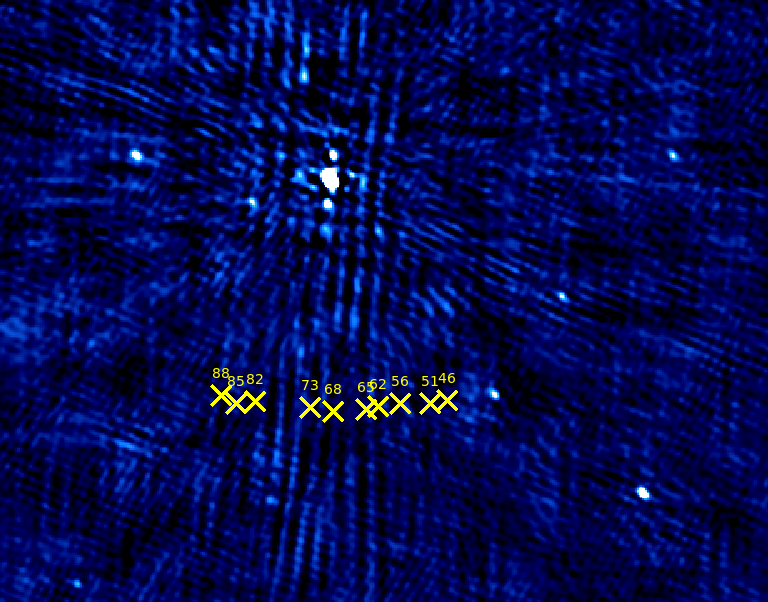

It is possible to filter these out of your false positives using a method developed for the AARTFAAC whole sky imager and outlined in the filtering stategies in [Kuiack et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.2966K/abstract). 
> "We found that excluding new source detections that occur within a space–time distance of 2.5° angular separation and 500 s was adequate to reject moving sources; these parameters were tuned using a sample data set which contained a number of transiting unidentified flying objects."

Sadly, with the advent of satellite constellations that are emitting or reflecting radiation (for LOFAR and Starlink see e.g. [Di Vruno et al.](https://ui.adsabs.harvard.edu/abs/2023A%26A...676A..75D/abstract)) and filters like this will likely become more important.

The following code is based upon the filtering strategy developed by Kuiack and his code is available here on [GitHub](https://github.com/mkuiack/scratchpad/blob/2664e6812f16003e4947839d7de8a9d474e8cbc4/scripts/StreamingHarvest.py#L532-L538)

In [66]:
# Loop through all the remaining candidates and remove sources associated in space (<2.5 deg) and time (<500 sec)
rejected_runcats=[]

for index, row in NewSrcDataFrame.iterrows():
    c1 = row.SkyCoord
    for index2, row2 in NewSrcDataFrame.iterrows():
        if index2 > index:
            c2 = row2.SkyCoord
            if (c1.separation(c2).deg < 2.5) and ((row2.TimeDetect-row.TimeDetect).total_seconds() < 600):
                rejected_runcats.append(row.RuncatID)
                rejected_runcats.append(row2.RuncatID)

rejected_runcats = np.unique(rejected_runcats)
rejected_runcats



array([1393, 1405, 1406, 1415, 1419, 1420, 1430, 1434, 1438, 1444, 1447,
       1449, 1452, 1453, 1458, 1461, 1464, 1467, 1471, 1475, 1476, 1477,
       1479, 1482, 1483, 1484, 1487, 1488, 1489, 1490, 1491])

In [67]:
NewSrcDataFrame = NewSrcDataFrame[~NewSrcDataFrame['RuncatID'].isin(rejected_runcats)]
NewSrcDataFrame

,RuncatID,ra,dec,xtrsrc,TimeDetect,detSigma,type,SkyCoord,detectImage,nearestSrc,nearestDeepSrc,nearestBrtSrc


#### Visual Inspection

The goal is to filter as many noise artefacts as possible before reaching this stage. But, visual inspection is often required before confirming a source is transient. Here we plot the light curve and the detection image, in the same way as we did for the variable source candidates.

In [68]:
images2 = session.query(Image).filter(Image.dataset_id == dataset_id).all()
images2 = pd.DataFrame(data=[[images[x].url,images[x].taustart_ts,np.around(images[x].band.freq_central/1e9, decimals=3)] for x in range(len(images))], columns=['Image','Time','Freq'])

for index, row in NewSrcDataFrame.iterrows():
    sourceID = row.RuncatID
    flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type'])
    lightcurve = pd.merge(lightcurve, images2, on="Image")

    print('Runcat = '+str(sourceID))
    print('RA: '+str(row.ra)+' Dec: '+str(row.dec))
    print('Image = '+row.detectImage)
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.type==0:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.type==1:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')

    extractedData, wcs = extract_data(row.detectImage,row.ra,row.dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)
    fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
 
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()
